# **TravelTide Mastery Project**

Intro to TravelTide:

E-booking startup TravelTide is a hot new player in the online travel industry. It has experienced steady growth since it was founded at the tail end of the COVID-19 pandemic (2021-04) on the strength of its data aggregation and search technology, which is best in class. Feedback from the customers has shown - and industry analysts agree - that TravelTide customers have access to the largest travel inventory in the e-booking space!
CEO Kevin Talanick is very motivated to retain and add value to existing customers with a Marketing strategy built on a solid understanding of customer behavior to improve customer retention.

Our mission as Data Analysts is two-fold:
First, we need to check if the data supports Elena’s hypothesis about the existence of customers that would be especially interested in the perks she is proposing.
Then, for each customer, assign a likely favorite perk.

TravelTide database has four different tables.
- users: user demographic information
- sessions: information about individual browsing sessions (note: only sessions with at least 2 clicks are included)
- Flights: information about purchased flights
- hotels: information about purchased hotel stays


# 1- Importing Libraries

In [6]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


# 2- Retreiving Data

In [7]:
df_data = pd.read_csv('Data/user_based_table.csv')


# 3- Data Exploration

- Selected Data has 5998 rows and 35 feature columns.
- there are no duplicated rows


In [8]:
# getting the basic info of df_data
print('basic df_data info','\n')
print( df_data.info() ,'\n')

#Fixing detypes of columns
df_data['user_id'] = df_data['user_id'].astype(object)
df_data.drop(['total_cancel_flights'], axis=1, inplace=True)

#Checking duplicates
df_data.duplicated().sum()

#Dealing with Nulls
df_data['total_discounted_flight'].fillna(0, inplace=True)
df_data['total_discounted_hotel'].fillna(0, inplace=True)


basic df_data info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         5998 non-null   int64  
 1   age                             5998 non-null   int64  
 2   gender                          5998 non-null   object 
 3   married                         5998 non-null   bool   
 4   has_children                    5998 non-null   bool   
 5   home_country                    5998 non-null   object 
 6   home_city                       5998 non-null   object 
 7   home_airport                    5998 non-null   object 
 8   user_since_days                 5998 non-null   int64  
 9   total_session                   5998 non-null   int64  
 10  total_clicks                    5998 non-null   int64  
 11  total_session_duration_sec      5998 non-null   float64
 12  trip_count   

/var/folders/gq/3d_53n2d05n2_n592s2dd_mr0000gn/T/ipykernel_96846/1903217403.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_data['total_discounted_flight'].fillna(0, inplace=True)
/var/folders/gq/3d_53n2d05n2_n592s2dd_mr0000gn/T/ipykernel_96846/1903217403.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

## i- Categorical Data analysis
- 5998 unique users
- 3 types of genders are present, out of which Females are in dominant number
- users can be with or without kids
- users can be married or not
- users belong to either USA or Canada only (2 home country)
- 105 unique cities are mentioned, most of the user belongs to New York.


In [9]:
df_data.describe(include= 'object').T

,count,unique,top,freq
user_id,5998,5998,568486,1
gender,5998,3,F,5292
home_country,5998,2,USA,4991
home_city,5998,105,New York,680
home_airport,5998,159,LGA,362


### User distribution over Demographic features


gender  married  has_children
F       False    False           2169
        True     False           1413
                 True             950
        False    True             760
M       False    False            310
        True     False            144
                 True             129
        False    True             112
O       True     True               5
        False    False              3
                 True               2
        True     False              1
Name: count, dtype: int64


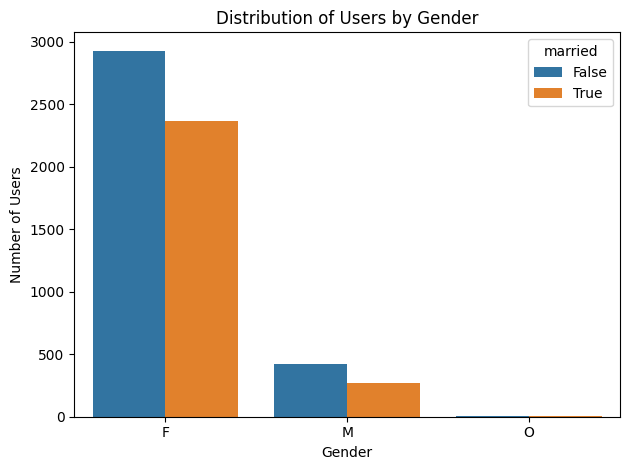

In [10]:
# group by demographic feature to see them in relation to each other
print(df_data.groupby('gender')[['married', 'has_children']].value_counts())
sns.countplot(x='gender', hue= 'married',  data=df_data)
plt.title('Distribution of Users by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

### User Age distribution
histogram plot is made to see the distribution of user's age. Majority of users are between 35 to 50 year sold.


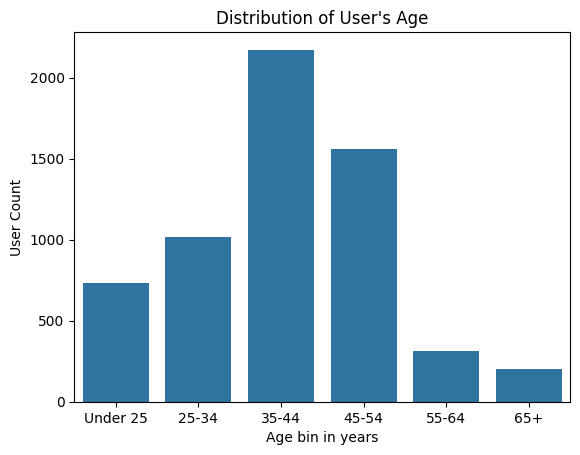

In [11]:
#Age group
# Define age ranges and corresponding labels
bins = [0, 25, 35, 45, 55, 65, float('inf')]
labels = ['Under 25', '25-34', '35-44', '45-54', '55-64', '65+']
# Create the 'age_group' column using pd.cut()
df_data['age_group'] = pd.cut(df_data['age'], bins=bins, labels=labels, include_lowest=True)

sns.countplot(x='age_group', data=df_data)
plt.title("Distribution of User's Age")
plt.xlabel('Age bin in years')
plt.ylabel('User Count')
plt.show()

### Successfull Trip count distribution
histogram plot is made to see the distribution of successful trips in users. Majority of users do 3 trips in total.


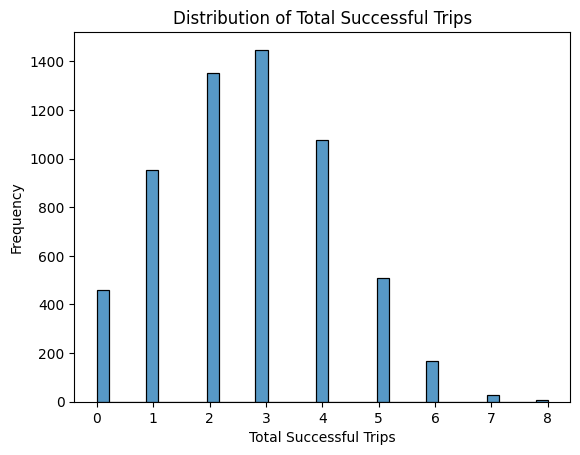

In [12]:
# Create the histogram
sns.histplot(data=df_data, x='total_successfull_trip')
plt.title('Distribution of Total Successful Trips')
plt.xlabel('Total Successful Trips')
plt.ylabel('Frequency')
plt.show()

# 4- Feature Engineering
Following new features have been generated using given features of dataset.
- Age group => users are devided in age bins
- Trip Cancellation rate => Num of cancellations /Num of trip bookings .
- Average Session Duration => total_session_duration_sec / total_sessions

- clicks per session => total_clicks / total_session

- Average seat booked=> Num_Booked_Seats / Num_Booked_Flights
- Average hotel room booked=> total Num Booked Rooms / total Num of times Hotels
- Average spend => Sum of Spend / Num_Bookings
- Flight frequency => total flights / total trips
- Average Hotel Stay => Num_Nights_Booked / Num_Trips_Booked
- average distance flown=> Total_Distance_Flown / Num_Flights_Booked
- Average Luggage => Sum_Checked_Bags / Num_Trips_Booked
- Average discounted flights => total_Flight_Discount / total_Flights_Booked
- Average discounted hotels=> total_discounted gotel / total hotel booking
- trip conversion rate => total successful trip/ total sessions

In [13]:
#Age group
# Define age ranges and corresponding labels
bins = [0, 25, 35, 45, 55, 65, float('inf')]
labels = ['Under 25', '25-34', '35-44', '45-54', '55-64', '65+']
# Create the 'age_group' column using pd.cut()
df_data['age_group'] = pd.cut(df_data['age'], bins=bins, labels=labels, include_lowest=True)

#Average Session Duration
df_data['avg_session_duration'] = df_data['total_session_duration_sec'] / df_data['total_session']
df_data['avg_session_duration'].fillna(-1, inplace=True)

#Clicks per Session
df_data['clicks_per_session'] = df_data['total_clicks'] / df_data['total_session']
df_data['clicks_per_session'].fillna(-1, inplace=True)

#Trip Cancellation rate
df_data['trip_cancellation_rate'] = df_data['total_cancellation'] / df_data['trip_count']
df_data['trip_cancellation_rate'].fillna(-1, inplace=True)
# df_data[df_data['trip_count']==0]['total_cancellation'].value_counts(), this give us 456 rows which are filled with -1
# because trip_count is 0 and total_cancellation are also 0. Hence represented as -1, as this needed to be treated differently


#Average seat booked
df_data['avg_seat_booked'] = df_data['total_seat'] / df_data['total_flight_booked']
df_data['avg_seat_booked'].fillna(-1, inplace=True)
df_data[['total_seat','total_flight_booked','avg_seat_booked']]

#Average hotel room booked
df_data['avg_room_booked'] = df_data['total_room'] / df_data['total_hotel_booking']
df_data['avg_room_booked'].fillna(-1, inplace=True)

#df_data[df_data['total_room']==0]['total_hotel_booking'].value_counts() 597 rows have 0 and filled with -1.
# Because total_hotel_booking is 0 and total_room are also 0


#Average spend
df_data['avg_spend'] = df_data['Total_spent'] / df_data['total_successfull_trip']
df_data['avg_spend'].fillna(-1, inplace=True)


#flight frequency
df_data['flight_trip_ratio'] = df_data['total_flight_booked'] / df_data['total_successfull_trip']
df_data['flight_trip_ratio'].fillna(-1, inplace=True)


#Hotel frequency
df_data['hotel_trip_ratio'] = df_data['total_hotel_booking'] / df_data['total_successfull_trip']
df_data['hotel_trip_ratio'].fillna(-1, inplace=True)
#df_data[df_data['total_successfull_trip']==0]['total_hotel_booking'].value_counts()

#Average hotel stay
df_data['avg_hotel_stay'] = df_data['total_nights'] / df_data['total_hotel_booking']
df_data['avg_hotel_stay'].fillna(-1, inplace=True)

#Average Distance Flown
df_data['avg_distance_flown'] = df_data['total_distance_flown_km'] / df_data['total_flight_booked']
df_data['avg_distance_flown'].fillna(-1, inplace=True)

#Average luggage
df_data['avg_luggage'] = df_data['total_checked_bags'] / df_data['total_flight_booked']
df_data['avg_luggage'].fillna(-1, inplace=True)

#Average discounted flight
df_data['avg_discounted_flight'] = df_data['total_discounted_flight'] / df_data['total_flight_booked']
df_data['avg_discounted_flight'].fillna(-1, inplace=True)

#average discounted hotel
df_data['avg_discounted_hotel'] = df_data['total_discounted_hotel'] / df_data['total_hotel_booking']
df_data['avg_discounted_hotel'].fillna(-1, inplace=True)

#trip conversion rate
df_data['trip_conversion_rate'] = df_data['total_successfull_trip'] / df_data['total_session']




/var/folders/gq/3d_53n2d05n2_n592s2dd_mr0000gn/T/ipykernel_96846/194052363.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_data['avg_session_duration'].fillna(-1, inplace=True)
/var/folders/gq/3d_53n2d05n2_n592s2dd_mr0000gn/T/ipykernel_96846/194052363.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

## ii- Numerical data exploration

In [14]:
df_data.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
age,5998.0,40.877459,12.044377,16.000,34.000000,41.000000,48.000000,88.000000
user_since_days,5998.0,117.898466,35.360982,0.000,102.000000,119.000000,130.000000,665.000000
total_session,5998.0,8.204568,0.460911,8.000,8.000000,8.000000,8.000000,12.000000
total_clicks,5998.0,144.308436,72.330165,33.000,102.000000,127.000000,161.000000,873.000000
total_session_duration_sec,5998.0,1536.304268,1985.672121,252.000,762.000000,953.500000,1208.000000,17101.000000
trip_count,5998.0,2.784595,1.570621,0.000,2.000000,3.000000,4.000000,9.000000
total_cancellation,5998.0,0.101701,0.310444,0.000,0.000000,0.000000,0.000000,2.000000
total_successfull_trip,5998.0,2.682894,1.521283,0.000,2.000000,3.000000,4.000000,8.000000
total_trip_duration_hrs,5998.0,296.590864,209.017822,0.000,144.000000,264.000000,408.000000,1608.000000
unique_destination_city,5998.0,2.165055,1.417076,0.000,1.000000,2.000000,3.000000,8.000000


### Features Distribution

Histograms

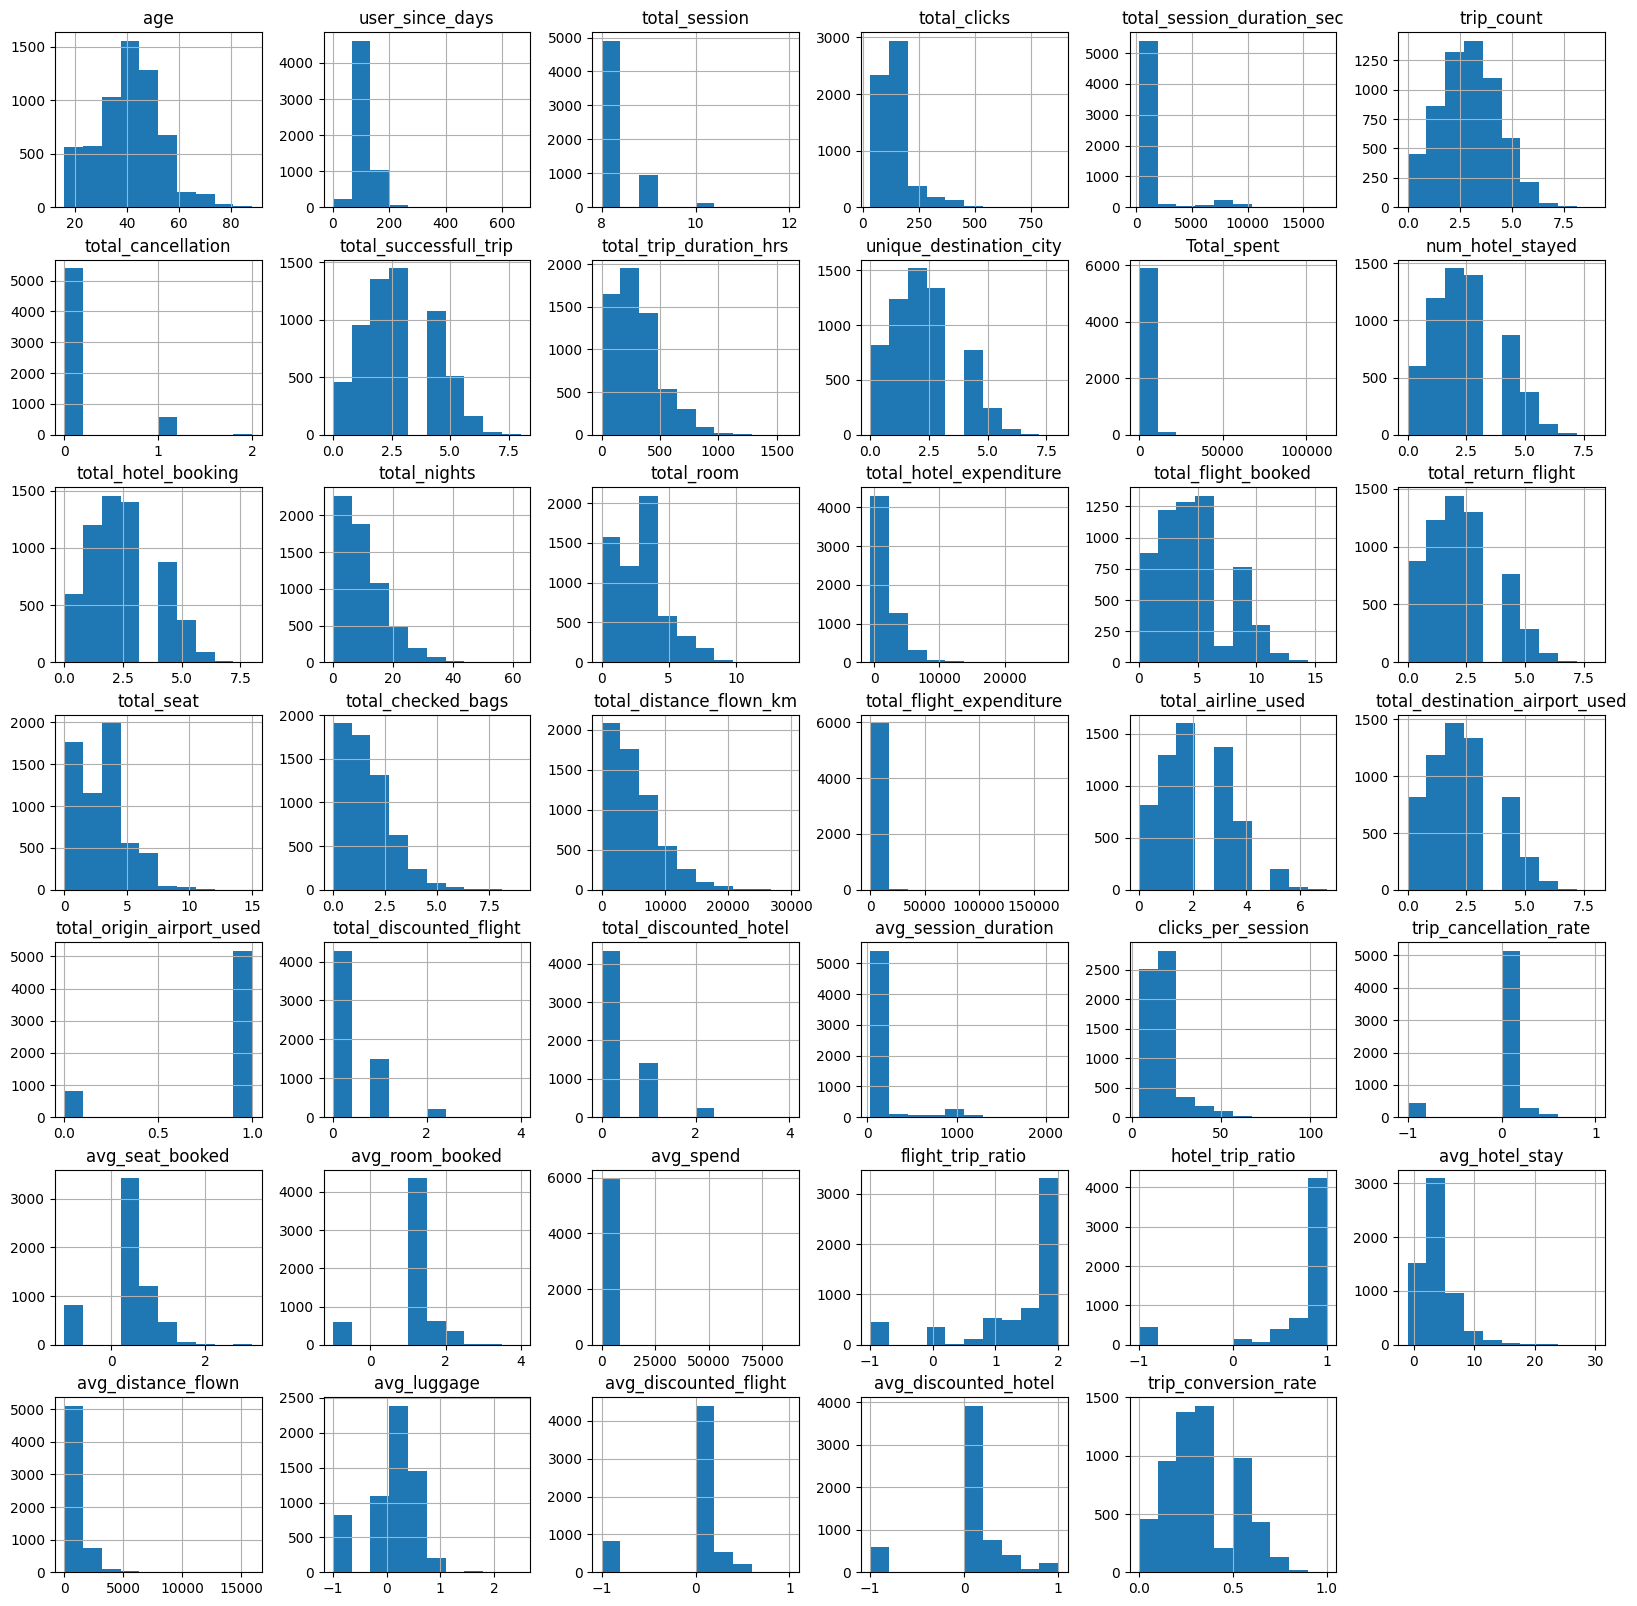

In [15]:
df_data.hist(figsize=(20,20))
plt.show()

# 5- Rule Based User Segmentation
## i- **Travel behavior**

is calculated looking at count of trips which are successfuly made by users and are not cancelled.

travel_behavior
Regular Travelers       2799
Frequent Travelers      1587
Occasional Travelers     955
Infrequent Travelers     458
travel_lovers            199
Name: count, dtype: int64


Text(0, 0.5, 'User Count')

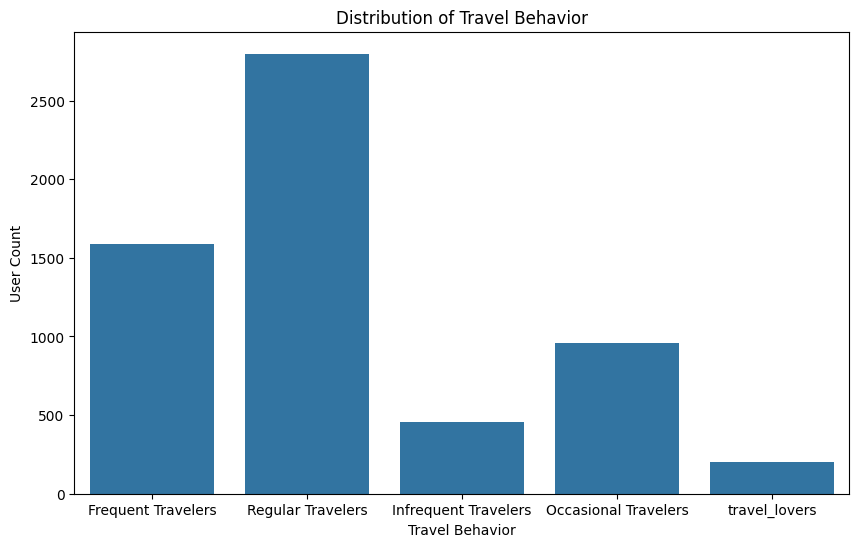

In [16]:
#Travel behavior

#Infrequent Travelers => total_successfull_trip = 0
#Occasional Travelers => total_successfull_trip = 1
#Regular Travelers    => <= 3 total_successfull_trip >= 2
#Frequent Travelers   => <= 5 total_successfull_trip >= 4
#travel_lovers        => total_successfull_trip > 5

def segment_user(row):
    if row['total_successfull_trip'] == 0:
        return 'Infrequent Travelers'
    elif row['total_successfull_trip'] == 1:
        return 'Occasional Travelers'
    elif row['total_successfull_trip'] <= 3 and row['total_successfull_trip'] >= 2:
        return 'Regular Travelers'
    elif row['total_successfull_trip'] <= 5 and row['total_successfull_trip'] >= 4:
        return 'Frequent Travelers'
    else:
        return 'travel_lovers'

df_data['travel_behavior'] = df_data.apply(segment_user, axis=1)

# Print the updated DataFrame or analyze the segments further
print(df_data['travel_behavior'].value_counts())


figure = plt.figure(figsize=(10, 6))
sns.countplot(x='travel_behavior', data=df_data)
plt.title('Distribution of Travel Behavior')
plt.xlabel('Travel Behavior')
plt.ylabel('User Count')






## ii- **Website Engagement**

total_session: Indicates the frequency of website visits.
total_clicks: Represents user interactivity within sessions.
total_session_duration_sec: Shows the time spent on the website, reflecting user interest.
By combining these metrics, a holistic view of user engagement is created and then
users are grouped by setting thresholds for each feature to categorize engagement levels, where
- Average Session Duration: total session duration devided by total number of session per user.
- Clicks per Session: average number of clicks per session for each user.

website_engagement_level
Medium    5526
High       413
V.High      59
Name: count, dtype: int64


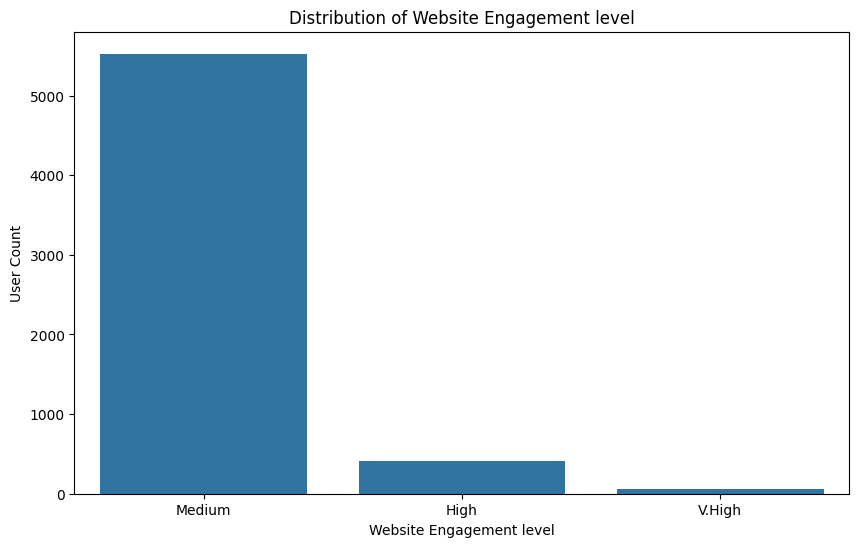

In [17]:
# Website Engagment Behavior
# Rule-Based Scoring: Define thresholds for each feature to categorize engagement levels.
def engagement_level(row):
    if row['avg_session_duration'] >= 1100 and row['clicks_per_session'] >= 50:
      return 'V.High'
    elif row['avg_session_duration'] >= 400 and row['clicks_per_session'] >= 22:
      return 'High'
    else:
      return 'Medium'

df_data['website_engagement_level'] = df_data.apply(engagement_level, axis=1)


# View the distribution of website engagement behavior categories
print(df_data['website_engagement_level'].value_counts())

figure = plt.figure(figsize=(10, 6))
sns.countplot(x='website_engagement_level', data=df_data)
plt.title('Distribution of Website Engagement level')
plt.xlabel('Website Engagement level')
plt.ylabel('User Count')
plt.show()

## iii- **Budgetary behavior**

By considering a combination of spending, trip frequency, travel choices, and discount preferences, a comprehensive understanding of user budgetary behavior is made to create user segmentation based on it.
  
- Average Spending per Trip:
This metric provides a baseline understanding of how much a user typically spends on a trip.
 Total_spent/total_successfull_trip.
- Spending Ratios:
df_data['Total_spent_on_flights'] / df_data['Total_spent'].
Hotel Spending Ratio:
These ratios can highlight preferences for spending on different travel components.
df_data['Total_spent_on_hotels'] / df_data['Total_spent'] .

- Discount Sensitivity:
Higher percentages suggest a greater focus on finding deals.
Flight Discount Percentage:
named as avg_discounted_flight = df_data['total_discounted_flight'] / df_data['total_flight_booked']
Hotel Discount Percentage: df_data['total_discounted_hotel'] / df_data['total_hotel_booking']


budget_behavior
economy_traveler             3830
no_spend                     1316
budget_sensitive_traveler     818
luxury_traveler                34
Name: count, dtype: int64


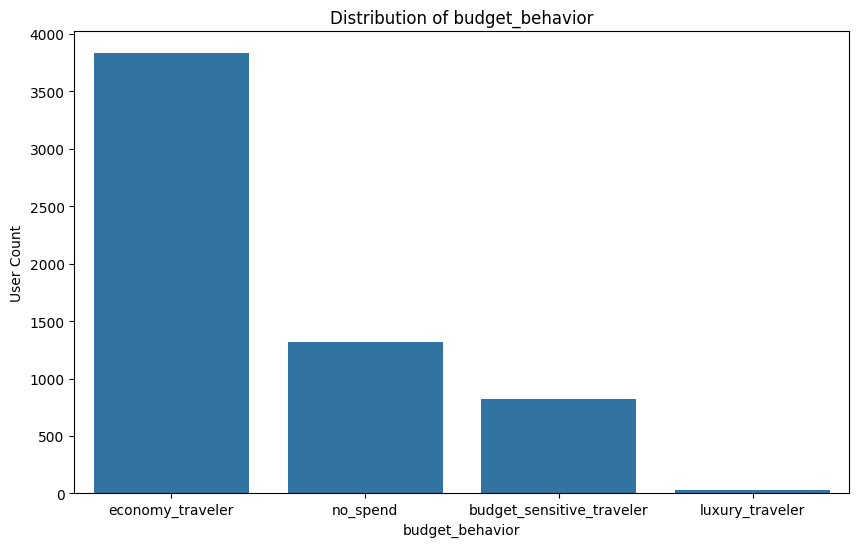

In [18]:
#Budgetary behavior

#  Adjust thresholds
def segment_user(row):
    if  row['avg_spend'] <=0:
        return 'no_spend'
    elif row['avg_spend'] <=1000 and (row['avg_discounted_flight'] > 0.3 or row['avg_discounted_hotel'] > 0.3):
        return 'budget_sensitive_traveler'
    elif row['avg_spend'] > 5000 and row['avg_discounted_flight'] <= 0.0 and row['avg_discounted_hotel'] <= 0.0:
        return 'luxury_traveler'
    else:
        return 'economy_traveler'

df_data['budget_behavior'] = df_data.apply(segment_user, axis=1)

# Print the updated DataFrame or analyze the segments further
print(df_data['budget_behavior'].value_counts())

figure = plt.figure(figsize=(10, 6))
sns.countplot(x='budget_behavior', data=df_data)
plt.title('Distribution of budget_behavior')
plt.xlabel('budget_behavior')
plt.ylabel('User Count')
plt.show()

## iv- **Flight booking behavior**
flight_trip_ratio, calculated as total_flight_booked / total_successfull_trip, provides insights into how frequently users book flights compared to their overall trips.
- Never_flown: Users with a Flight trip ratio close to 0. These users rarely or never book flights for their trips, perhaps preferring other modes of travel.
- rare_flight_booker: Users with a Flight trip ratio around 0.7. These users book flights sometimes but not for every trip.

- Occasional Flight Bookers:  Users with a Flight trip ratio less than 1.5. These users tend to book flights for most of their trips.

- Frequent Flight Bookers: Users with a Flight trip ratio greater than 1.5 but less than 2. These users frequently book flights perhaps not every time return flight is booked.

- Primarily Flight Bookers: Users with a Flight trip ratio equal to 2 (1+1 departing+return flight). These users exclusively use both way flights for their trips.

flight_booking_segment
primarily_flight_booker     3124
occasional_flight_booker    1042
frequent_flight_booker       895
never_flown                  820
rare_flight_booker           117
Name: count, dtype: int64


Text(0.5, 0, 'flight_booking_segment')

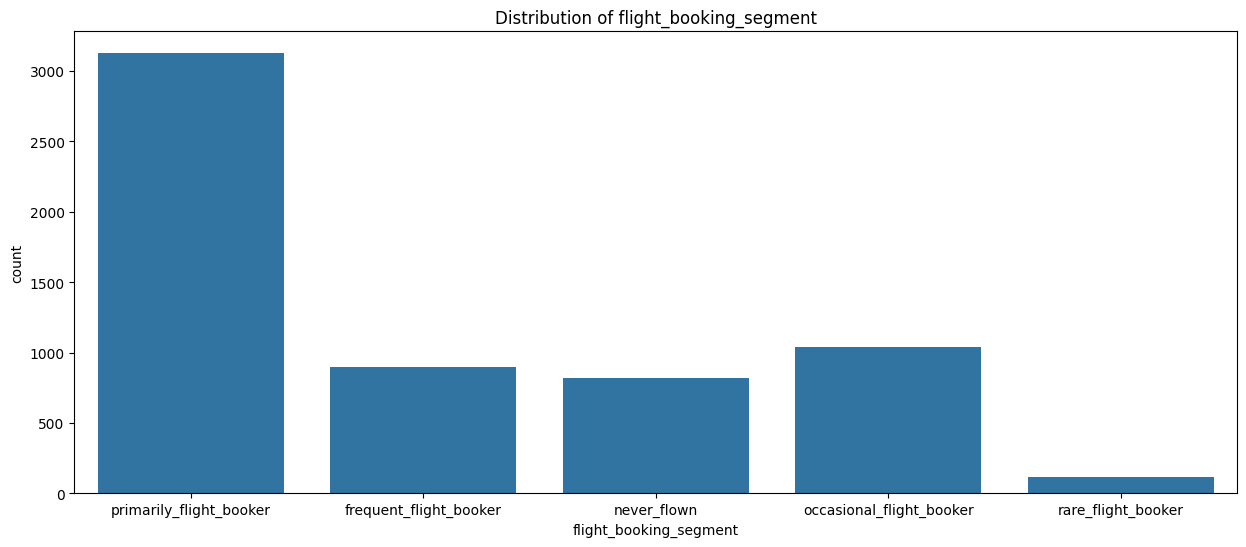

In [19]:
# Create a Segmentation Function:
def segment_by_flight_ratio(row):
    ratio = row['flight_trip_ratio']
    if   ratio <=0:
        return 'never_flown'
    elif ratio <= 0.7:
        return 'rare_flight_booker'
    elif ratio < 1.5:
        return 'occasional_flight_booker'
    elif ratio < 2:
        return 'frequent_flight_booker'
    else:
        return 'primarily_flight_booker'

# Apply the Segmentation:
df_data['flight_booking_segment'] = df_data.apply(segment_by_flight_ratio, axis=1)

# Print the updated DataFrame or analyze the segments further
print(df_data['flight_booking_segment'].value_counts())

figure = plt.figure(figsize=(15, 6))
sns.countplot(x='flight_booking_segment', data=df_data)
plt.title('Distribution of flight_booking_segment')
plt.xlabel('flight_booking_segment')

## v- **Demographic trip type**

 By looking on to the information for each traveler (marital status, children, seats booked) they are are being assigned to the appropriate category.
 Family Trip:

These are married travelers who also have children.
They booked at least 2 seats, suggesting they are traveling with their family.
Work Trip:

These are also married travelers with children.
But they only booked 1 seat, indicating they are likely traveling alone for work purposes.
Single Parent Trip:

These travelers are not married but have children.
They booked at least 2 seats, suggesting they are traveling with their children as a single parent.
Single Traveller:

This is the catch-all category for everyone else:
Travelers who are not married and don't have children.
Travelers who booked only 1 seat, regardless of their marital status or whether they have children.



Text(0.5, 0, 'demographic_trip_type')

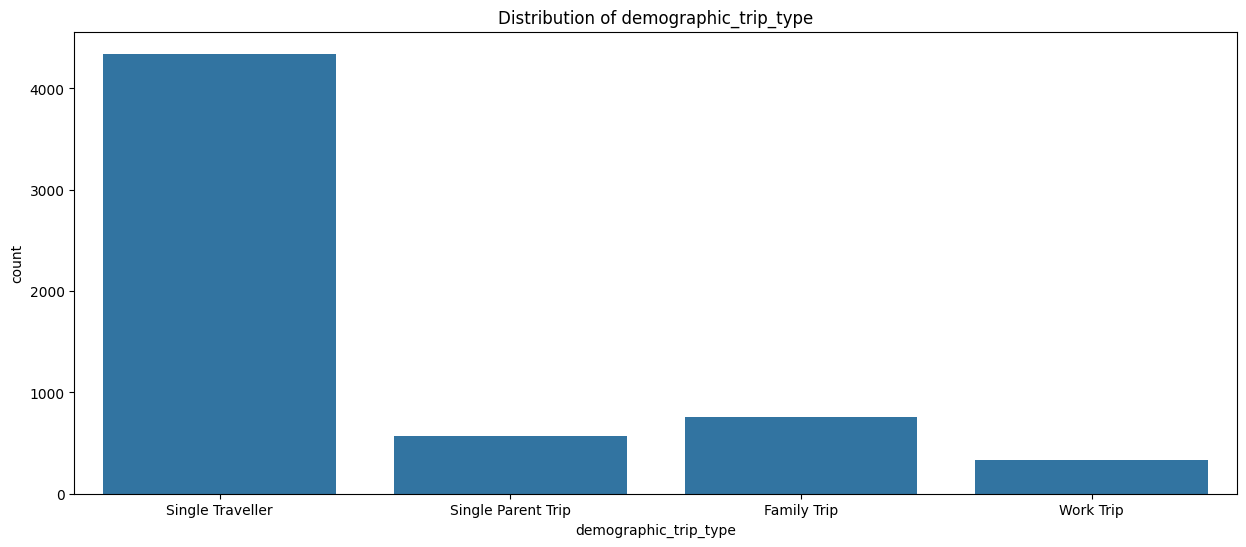

In [20]:
# Demographic_trip type:
# married & has children & seats booked >= 2 -> Family Trip
# married & has children & seats booked < 2 -> work trip
# not married & has children & seats booked >= 2 -> Single parent trip
# not married & no children & seat booked < 2 -> single traveller

def demographic_trip_type(row):
    if row['married'] and row['has_children'] and row['total_seat'] >= 2:
        return 'Family Trip'
    elif row['married'] and row['has_children'] and row['total_seat'] < 2:
        return 'Work Trip'
    elif not row['married'] and row['has_children'] and row['total_seat'] >= 2:
        return 'Single Parent Trip'
    else:
        return 'Single Traveller'

df_data['demographic_trip_type'] = df_data.apply(demographic_trip_type, axis=1)

# Print the updated DataFrame or analyze the segments further
df_data['demographic_trip_type'].value_counts(sort=False)

figure = plt.figure(figsize=(15, 6))
sns.countplot(x='demographic_trip_type', data=df_data)
plt.title('Distribution of demographic_trip_type')
plt.xlabel('demographic_trip_type')

## vi- Life stage based segement

life_stage_segement
senior_couple          473
single                3356
established_couple    1104
established_family     847
young_family            86
young_couple           132
Name: count, dtype: int64


<Axes: xlabel='life_stage_segement', ylabel='count'>

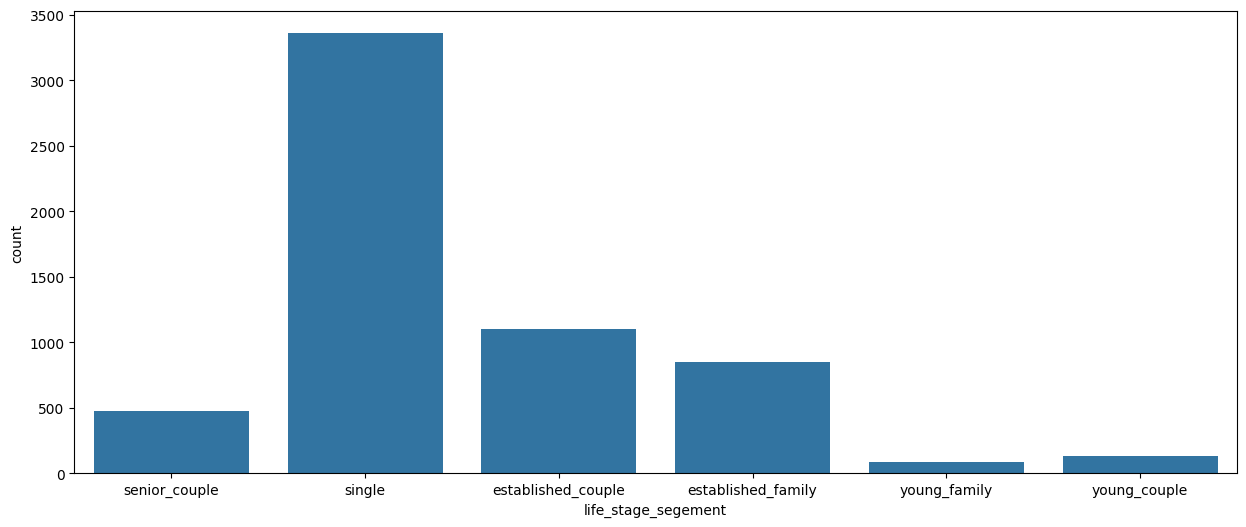

In [21]:
def life_stage_segement(cust_row):
    """
    Classify customers based on their life stage using age, marital status,
    and whether they have children.

    Parameters:
        cust_row: A row from the customers dataframe

    Returns:
        String: life_stage_segement
    """
def life_stage_segment(cust_row):
    if not cust_row["married"]:  # Check for single status first
        return "single"  # Combine all singles into one category
    elif cust_row["age"] < 25 and cust_row["married"]:
        return "young_couple"
    elif cust_row["age"] < 35:
        if cust_row["married"] and cust_row["has_children"]:
            return "young_family"
        elif cust_row["married"]:
            return "young_couple"
    elif cust_row["age"] < 55:
        if cust_row["married"] and cust_row["has_children"]:
            return "established_family"
        elif cust_row["married"]:
            return "established_couple"
    else:
        if cust_row["married"]:
            return "senior_couple"

# Apply the function
df_data["life_stage_segement"] = df_data.apply(life_stage_segment, axis=1)

print(df_data["life_stage_segement"].value_counts(sort=False))

figure = plt.figure(figsize=(15, 6))
sns.countplot(x='life_stage_segement', data=df_data)

## vii- Hotel stay behavior
calculated on basis of average hotel stay of a user in his trip.

Text(0.5, 0, 'hotel_stay_behavior')

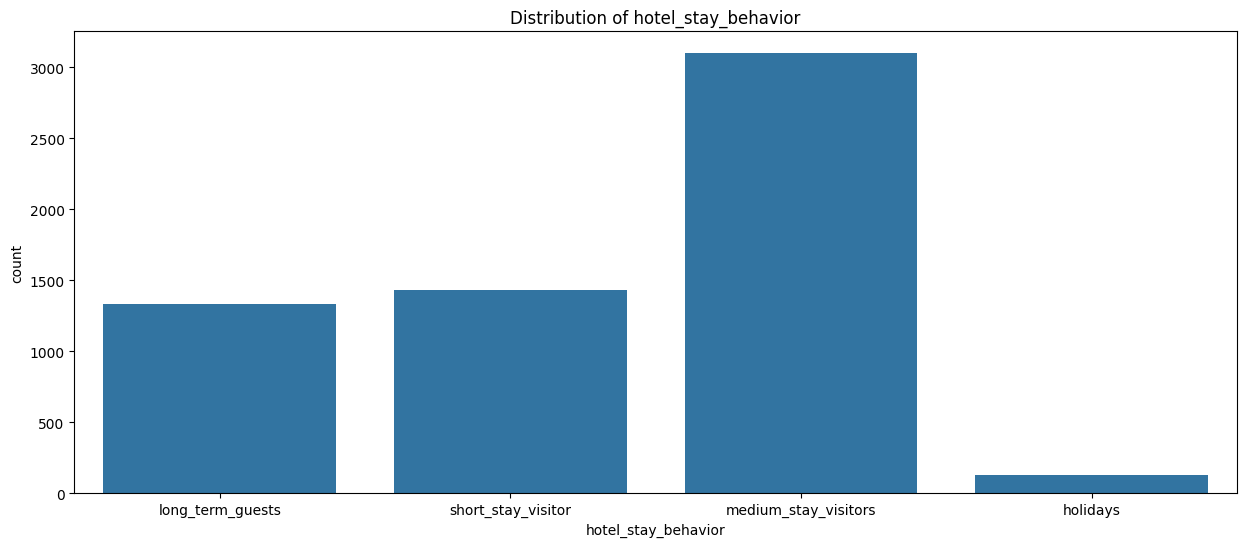

In [22]:
# Hotel Stay behavior
# 1. Short stay visitors  avg_hotel_stay <=2
# 2. Medium stay visitors avg_hotel_stay <=5
# 3. Long term guests     avg_hotel_stay <=12
# 4. Holidays             avg_hotel_stay >12

def segment_hotel_stay(row):
    if row['avg_hotel_stay'] <= 2:
        return 'short_stay_visitor'
    elif row['avg_hotel_stay'] <= 5:
        return 'medium_stay_visitors'
    elif row['avg_hotel_stay'] <= 12:
        return 'long_term_guests'
    else:
        return 'holidays'



df_data['hotel_stay_behavior'] = df_data.apply(segment_hotel_stay, axis=1)

figure = plt.figure(figsize=(15, 6))
sns.countplot(x='hotel_stay_behavior', data=df_data)
plt.title('Distribution of hotel_stay_behavior')
plt.xlabel('hotel_stay_behavior')

## vii- Hotel booking behavior

hotel_booking_behavior
primarily_booker      4069
frequent_booker        858
never_stayed_hotel     597
occassional_booker     402
rare_booker             72
Name: count, dtype: int64


Text(0.5, 0, 'hotel_booking_behavior')

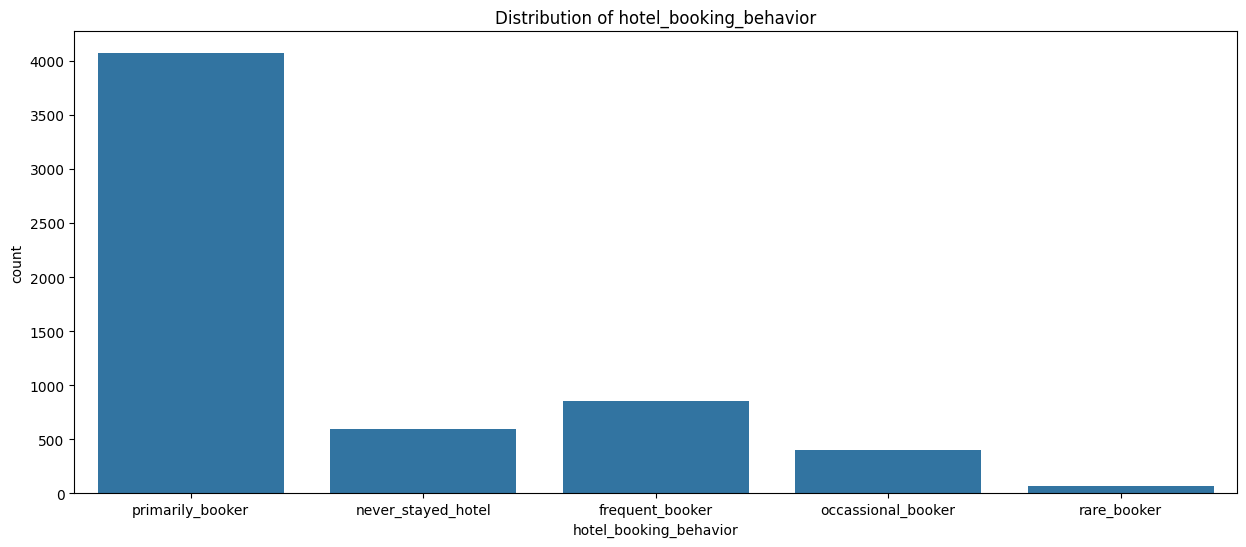

In [23]:
# hotel_booking_behavior
# Define bins and labels
# 1. never_stayed_hotel
# 2. rare_booker
# 3. ocassional_booker
# 4. freuqnet_booker
# 5. primarly_booker

def segment_hotel_booking(row):
    ratio = row['hotel_trip_ratio']
    if   ratio <=0:
        return 'never_stayed_hotel'
    elif ratio <= 0.4:
        return 'rare_booker'
    elif ratio <= 0.6:
        return 'occassional_booker'
    elif ratio <= 0.8:
        return 'frequent_booker'
    else:
        return 'primarily_booker'

df_data['hotel_booking_behavior'] = df_data.apply(segment_hotel_booking, axis=1)

# Print the updated DataFrame or analyze the segments further
print(df_data['hotel_booking_behavior'].value_counts())

figure = plt.figure(figsize=(15, 6))
sns.countplot(x='hotel_booking_behavior', data=df_data)
plt.title('Distribution of hotel_booking_behavior')
plt.xlabel('hotel_booking_behavior')




## Creating value Score of customers

**Defination:**

A value scoring system for user behavior categories (travel, engagement, budget, etc.) is created by assigning numerical value scores to each category within each segmented column of df_dat. then Weights for each column is given to represent their importance to traveltide.

**Calculation Weighted Scores:**

For each column
- Converts the categorical column to value score (using .cat.codes).
- Maps numerical values to the corresponding score.
- Multiplies the score by the column's weight to get the weighted score.

**Calculate Overall Score:**
- Initializes an overall_score column to 0.
- Adds up the weighted score from each column to get the `value_score`.
- Stores the overall_score in a new column of df_data
- In a nutshell
- The code assigns a final value score to each user based on travel patterns, website usage, and budget.



In [24]:
score_mappings = {
        'travel_behavior': {'Infrequent Travelers': 0, 'Occasional Travelers': 1, 'Regular Travelers': 2, 'Frequent Travelers': 3, 'travel_lovers': 4},
        'website_engagement_level': {'V.High': 3, 'High': 2, 'Medium': 1},
        'budget_behavior': {'no_spend': 0, 'economy_traveler': 1, 'budget_sensitive_traveler': 2, 'luxury_traveler': 3},
        'flight_booking_segment': {'never_flown': 0, 'rare_flight_booker': 1, 'occasional_flight_booker': 2, 'frequent_flight_booker': 3, 'primarily_flight_booker': 4},
        'hotel_stay_behavior': {'short_stay_visitor': 1, 'medium_stay_visitors': 2, 'long_term_guests': 3, 'holidays': 4},
        'hotel_booking_behavior': {'never_stayed_hotel': 0, 'rare_booker': 1, 'occassional_booker': 2, 'frequent_booker': 3, 'primarily_booker': 4},
    }

    # Define weights for each column
weights = {
        'travel_behavior': 1,
        'website_engagement_level': 1,
        'budget_behavior': 1,
        'flight_booking_segment': 1,
        'hotel_stay_behavior': 1,
        'hotel_booking_behavior': 1,
    }

cols = ['user_id',
    'travel_behavior',
     'website_engagement_level',
     'budget_behavior',
     'flight_booking_segment',
     'hotel_stay_behavior',
     'hotel_booking_behavior']

# Initialize the overall score column with 0s
df_data['value_score'] = 0

# Calculate the weighted score for each column and add to overall_score
for column, mapping in score_mappings.items():
    # Create a dictionary mapping categories to scores using index
    category_to_score = dict(enumerate(mapping.values()))

    # Convert to numerical using .cat.codes
    numerical_values = df_data[column].astype('category').cat.codes

    # Map numerical values to scores and multiply by weight
    weighted_score_column = numerical_values.map(category_to_score) * weights[column]

    # Add the weighted score for this column to the overall score
    df_data['value_score'] = df_data['value_score'] + weighted_score_column

#df_data['overall_score'].value_counts(sort=True)    uncomment to see the value count

## Applying Score based Clustering

value_score range is used to cluster the users, and they are divided into 4 groups based on histogram analysis of `value_score`.

In [25]:
def score_based_clusters(row):
    score = row['value_score']
    if   score <=10:
        return 'cluster_1'
    elif score <= 13:
        return 'cluster_2'
    elif score <= 15:
        return 'cluster_3'
    else:
        return 'cluster_4'

df_data['score_based_clusters'] = df_data.apply(score_based_clusters, axis=1)

# Print the updated DataFrame or analyze the segments further
print(df_data['score_based_clusters'].value_counts())

#Applying perks for each user according to its cluster group

def perks(value):

  if value == 'cluster_1':
    return "Flaxi flyer Pass: 3% Personal Discount next flight, valid 1 year"
  elif value == 'cluster_2':
    return "Welcome_Aboard: 10% Discount for Next Booking valid 6 months"
  elif value == 'cluster_3':
    return "Free Child's Flight or Hotel Stay (with accompanying adult booking)"
  elif value == 'cluster_4':
    return "Extended Stay Saver: Free musium Pass for hotel stays of 3 nights "

df_data['perk'] = df_data["score_based_clusters"].apply(perks)
df_data["perk"].value_counts()

score_based_clusters
cluster_2    2223
cluster_3    2127
cluster_1    1072
cluster_4     576
Name: count, dtype: int64


perk
Welcome_Aboard: 10% Discount for Next Booking valid 6 months           2223
Free Child's Flight or Hotel Stay (with accompanying adult booking)    2127
Flaxi flyer Pass: 3% Personal Discount next flight, valid 1 year       1072
Extended Stay Saver: Free musium Pass for hotel stays of 3 nights       576
Name: count, dtype: int64

# 6- EDA for score_based_clusters

In [26]:
# categorical feature. descrtiption of score_based_clusters
print('cluster_1', df_data[df_data['score_based_clusters']=='cluster_1'].describe(include='object').T, '\n','\n'
'cluster_2', df_data[df_data['score_based_clusters']=='cluster_2'].describe(include='object').T, '\n','\n'
'cluster_3',df_data[df_data['score_based_clusters']=='cluster_3'].describe(include='object').T, '\n','\n'
'cluster_4',df_data[df_data['score_based_clusters']=='cluster_4'].describe(include='object').T)


cluster_1                          count unique  \
user_id                   1072   1072   
gender                    1072      3   
home_country              1072      2   
home_city                 1072    101   
home_airport              1072    145   
travel_behavior           1072      3   
website_engagement_level  1072      3   
budget_behavior           1072      3   
flight_booking_segment    1072      3   
demographic_trip_type     1072      3   
life_stage_segement       1072      6   
hotel_stay_behavior       1072      4   
hotel_booking_behavior    1072      4   
score_based_clusters      1072      1   
perk                      1072      1   

                                                                        top  \
user_id                                                              569150   
gender                                                                    F   
home_country                                                            USA   
home_city        

user count in score_based_clusters and there value_score  
                      user_id value_score     avg_spend
                       count        mean           sum
score_based_clusters                                  
cluster_1               1072    8.276119  7.368600e+05
cluster_2               2223   12.186235  1.489052e+06
cluster_3               2127   14.530795  1.904086e+06
cluster_4                576   16.260417  3.057547e+05 
 
 
 Demographic feture distribution in score_based_clusters 



married                     False       True       
has_children                False True  False True 
score_based_clusters gender                        
cluster_1            F        392   127   274   158
                     M         52     8    33    25
                     O          0     1     1     1
cluster_2            F        821   283   525   316
                     M        120    52    59    44
                     O          2     0     0     1
cluster_3            F        748   280   474   383
                     M        111    37    41    48
                     O          1     1     0     3
cluster_4            F        208    70   140    93
                     M         27    15    11    12

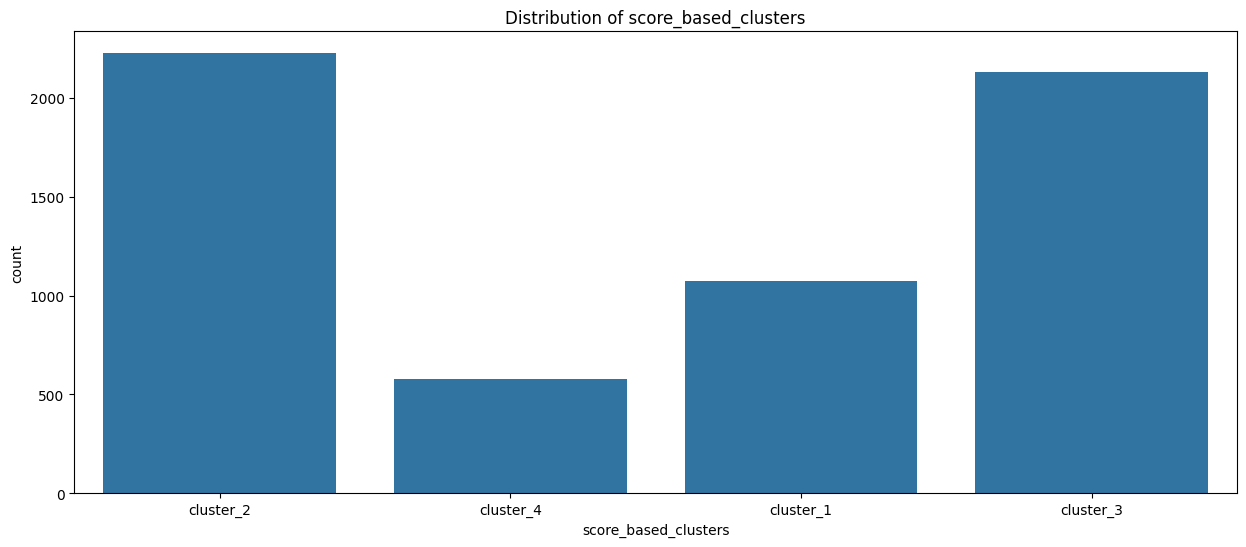

In [27]:
#user count in score_based_clusters and there value_score
print('user count in score_based_clusters and there value_score ','\n', df_data.groupby('score_based_clusters').agg({'user_id': 'count', 'value_score': [ 'mean'], 'avg_spend': 'sum' }),'\n','\n','\n','Demographic feture distribution in score_based_clusters','\n',)
figure = plt.figure(figsize=(15, 6))
sns.countplot(x='score_based_clusters', data=df_data)
plt.title('Distribution of score_based_clusters')
plt.xlabel('score_based_clusters')


#Demographic feture distribution in score_based_clusters
pd.pivot_table(df_data,
								values='user_id',
                index=['score_based_clusters', 'gender'],
                columns=['married','has_children'],
                aggfunc='count',
                fill_value=0)

score_based_clusters  age_group
cluster_1             35-44        534
                      45-54        345
                      25-34        152
                      55-64         30
                      Under 25      10
                      65+            1
cluster_2             35-44        716
                      45-54        532
                      Under 25     380
                      25-34        359
                      65+          124
                      55-64        112
cluster_3             35-44        706
                      45-54        537
                      25-34        407
                      Under 25     276
                      55-64        134
                      65+           67
cluster_4             35-44        217
                      45-54        146
                      25-34        100
                      Under 25      66
                      55-64         35
                      65+           12
Name: count, dtype: int64


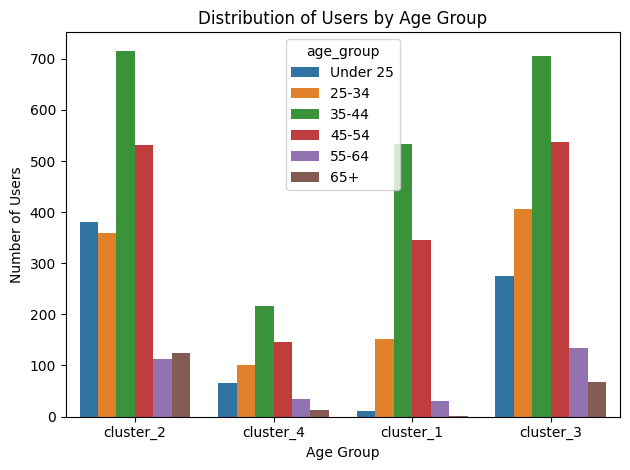

In [28]:

# Age distribution in score_based_clusters
print(df_data.groupby('score_based_clusters')[['age_group']].value_counts())
sns.countplot(x='score_based_clusters', hue= 'age_group',   data=df_data)
plt.title('Distribution of Users by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [29]:
# assuming customers are engaged only in looking website, probably have money issue to result less trip
pd.pivot_table(df_data,
								values='user_id',
                index=['score_based_clusters','budget_behavior'],
                columns=['travel_behavior', 'website_engagement_level'],# 'budget_behavior', 'flight_booking_segment', 'hotel_stay_behavior', 'hotel_booking_behavior
                aggfunc='count',
                fill_value=0)

travel_behavior                                Frequent Travelers         \
website_engagement_level                                     High Medium   
score_based_clusters budget_behavior                                       
cluster_1            budget_sensitive_traveler                 12    163   
                     economy_traveler                          61    725   
                     no_spend                                   0     12   
cluster_2            budget_sensitive_traveler                  6     25   
                     economy_traveler                          47    493   
                     luxury_traveler                            0      0   
                     no_spend                                   1      4   
cluster_3            budget_sensitive_traveler                  0      0   
                     economy_traveler                           2      2   
                     luxury_traveler                            0      0   
                     no_spend                                   1      5   
cluster_4            budget_sensitive_traveler                  0      0   
                     economy_traveler                           0      0   
                     luxury_traveler                            0      0   
                     no_spend                                   0      0   

travel_behavior                                       Infrequent Travelers  \
website_engagement_level                       V.High                 High   
score_based_clusters budget_behavior                                         
cluster_1            budget_sensitive_traveler      6                    0   
                     economy_traveler              12                    0   
                     no_spend                       1                    0   
cluster_2            budget_sensitive_traveler      0                    0   
                     economy_traveler               9                    0   
                     luxury_traveler                0                    0   
                     no_spend                       0                    1   
cluster_3            budget_sensitive_traveler      0                    0   
                     economy_traveler               0                    0   
                     luxury_traveler                0                    0   
                     no_spend                       0                    0   
cluster_4            budget_sensitive_traveler      0                    0   
                     economy_traveler               0                    0   
                     luxury_traveler                0                    0   
                     no_spend                       0                    0   

travel_behavior                                       Occasional Travelers  \
website_engagement_level                       Medium                 High   
score_based_clusters budget_behavior                                         
cluster_1            budget_sensitive_traveler      0                    0   
                     economy_traveler               0                    0   
                     no_spend                       0                    0   
cluster_2            budget_sensitive_traveler      0                    0   
                     economy_traveler               0                    4   
                     luxury_traveler                0                    0   
                     no_spend                     457                    1   
cluster_3            budget_sensitive_traveler      0                    2   
                     economy_traveler               0                   13   
                     luxury_traveler                0                    4   
                     no_spend                       0                    3   
cluster_4            budget_sensitive_traveler      0                    0   
                     economy_traveler               0   

In [30]:
#customers they travel a lot but not often book flight.
pd.pivot_table(df_data,
								values='user_id',
                index=['score_based_clusters','flight_booking_segment' ],
                columns=['travel_behavior','life_stage_segement'] ,# ,'budget_behavior', 'hotel_stay_behavior', 'hotel_booking_behavior
                aggfunc='count',
                fill_value=0)

travel_behavior                               Frequent Travelers  \
life_stage_segement                           established_couple   
score_based_clusters flight_booking_segment                        
cluster_1            frequent_flight_booker                  148   
                     occasional_flight_booker                 29   
                     primarily_flight_booker                  73   
cluster_2            frequent_flight_booker                    0   
                     never_flown                               0   
                     occasional_flight_booker                 16   
                     primarily_flight_booker                 128   
                     rare_flight_booker                        3   
cluster_3            frequent_flight_booker                    0   
                     never_flown                               0   
                     occasional_flight_booker                  0   
                     primarily_flight_booker                   3   
                     rare_flight_booker                        0   
cluster_4            never_flown                               0   
                     occasional_flight_booker                  0   
                     primarily_flight_booker                   0   
                     rare_flight_booker                        0   

travel_behavior                                                   \
life_stage_segement                           established_family   
score_based_clusters flight_booking_segment                        
cluster_1            frequent_flight_booker                   89   
                     occasional_flight_booker                 26   
                     primarily_flight_booker                  36   
cluster_2            frequent_flight_booker                    1   
                     never_flown                               0   
                     occasional_flight_booker                 17   
                     primarily_flight_booker                  66   
                     rare_flight_booker                        0   
cluster_3            frequent_flight_booker                    0   
                     never_flown                               0   
                     occasional_flight_booker                  0   
                     primarily_flight_booker                   3   
                     rare_flight_booker                        0   
cluster_4            never_flown                               0   
                     occasional_flight_booker                  0   
                     primarily_flight_booker                   0   
                     rare_flight_booker                        0   

travel_behavior                                                     \
life_stage_segement                           senior_couple single   
score_based_clusters flight_booking_segment                          
cluster_1            frequent_flight_booker              24    337   
                     occasional_flight_booker             8     61   
                     primarily_flight_booker              4    139   
cluster_2            frequent_flight_booker               1      0   
                     never_flown                          0      0   
                     occasional_flight_booker             1     48   
                     primarily_flight_booker             13    277   
                     rare_flight_booker                   1      4   
cluster_3            frequent_flight_booker               0      0   
                     never_flown                          0      0   
                     occasional_flight_booker             0      1   
                     primarily_flight_booker              0      0   
                     rare_flight_booker                   2      1   
cluster_4            never_flown                          0      0   
                     occasional_flight_booker             0      0   
                  

In [31]:
#customers who travel a lot but do not book hotel
pd.pivot_table(df_data,
								values='user_id',
                index=['score_based_clusters','life_stage_segement' ],
                columns=['budget_behavior','hotel_stay_behavior',],#travel_behavior','life_stage_segement','budget_behavior',website_engagement_level, 'flight_booking_segment', 'hotel_stay_behavior', 'hotel_booking_behavior'
                aggfunc='count',
                fill_value=0)

budget_behavior                          budget_sensitive_traveler  \
hotel_stay_behavior                                       holidays   
score_based_clusters life_stage_segement                             
cluster_1            established_couple                          0   
                     established_family                          1   
                     senior_couple                               0   
                     single                                      2   
                     young_couple                                0   
                     young_family                                0   
cluster_2            established_couple                          0   
                     established_family                          0   
                     senior_couple                               0   
                     single                                      1   
                     young_couple                                0   
                     young_family                                0   
cluster_3            established_couple                          0   
                     established_family                          0   
                     senior_couple                               0   
                     single                                      0   
                     young_couple                                0   
                     young_family                                0   
cluster_4            established_couple                          0   
                     established_family                          0   
                     senior_couple                               0   
                     single                                      0   
                     young_couple                                0   
                     young_family                                0   

budget_behavior                                            \
hotel_stay_behavior                      long_term_guests   
score_based_clusters life_stage_segement                    
cluster_1            established_couple                17   
                     established_family                16   
                     senior_couple                      2   
                     single                            25   
                     young_couple                       1   
                     young_family                       1   
cluster_2            established_couple                13   
                     established_family                15   
                     senior_couple                      8   
                     single                            52   
                     young_couple                       5   
                     young_family                       2   
cluster_3            established_couple                 5   
                     established_family                 3   
                     senior_couple                      1   
                     single                             7   
                     young_couple                       3   
                     young_family                       0   
cluster_4            established_couple                 0   
                     established_family                 0   
                     senior_couple                      0   
                     single                             0   
                     young_couple                       0   
                     young_family                       0   

budget_behavior                                                \
hotel_stay_behavior                      medium_stay_visitors   
score_based_clusters life_stage_segement                        
cluster_1            established_couple                    48   
                     established_family                    16   
                     senior_couple                          4   
                     single                                68   
      

In [32]:
pd.pivot_table(df_data,
								values='user_id',
                index=['score_based_clusters', 'budget_behavior'],
                columns='flight_booking_segment',
                aggfunc='count',
                fill_value=0)

flight_booking_segment                          frequent_flight_booker  \
score_based_clusters budget_behavior                                     
cluster_1            budget_sensitive_traveler                      95   
                     economy_traveler                              543   
                     no_spend                                        8   
cluster_2            budget_sensitive_traveler                      47   
                     economy_traveler                              189   
                     luxury_traveler                                 0   
                     no_spend                                        2   
cluster_3            budget_sensitive_traveler                       0   
                     economy_traveler                                8   
                     luxury_traveler                                 0   
                     no_spend                                        3   
cluster_4            budget_sensitive_traveler                       0   
                     economy_traveler                                0   
                     luxury_traveler                                 0   
                     no_spend                                        0   

flight_booking_segment                          never_flown  \
score_based_clusters budget_behavior                          
cluster_1            budget_sensitive_traveler            0   
                     economy_traveler                     0   
                     no_spend                             0   
cluster_2            budget_sensitive_traveler            0   
                     economy_traveler                     0   
                     luxury_traveler                      0   
                     no_spend                           640   
cluster_3            budget_sensitive_traveler            0   
                     economy_traveler                     0   
                     luxury_traveler                      0   
                     no_spend                           177   
cluster_4            budget_sensitive_traveler            0   
                     economy_traveler                     0   
                     luxury_traveler                      0   
                     no_spend                             3   

flight_booking_segment                          occasional_flight_booker  \
score_based_clusters budget_behavior                                       
cluster_1            budget_sensitive_traveler                        51   
                     economy_traveler                                107   
                     no_spend                                          5   
cluster_2            budget_sensitive_traveler                       179   
                     economy_traveler                                279   
                     luxury_traveler                                   1   
                     no_spend                                         14   
cluster_3            budget_sensitive_traveler                        13   
                     economy_traveler                                247   
                     luxury_traveler                                   4   
                     no_spend                                         85   
cluster_4            budget_sensitive_traveler                         0   
                     economy_traveler                                  1   
                     luxury_traveler                                   0   
                     no_spend                                         56   

flight_booking_segment                          primarily_flight_booker  \
score_based_clusters budget_behavior                                      
cluster_1            budget_sensitive_traveler                       68   
                     economy_traveler                               195   
                     no_spend                                         0   
c

In [33]:
pd.pivot_table(df_data,
	# the aggregation function will be applied on Sales
								values='user_id',
 # the results will be grouped by Region through the index of
 # the new table
                index=['score_based_clusters', 'life_stage_segement'],
 # the results will be grouped by Product through the columns of
 # the new table
                columns=['hotel_booking_behavior'], #, 'budget_behavior', 'flight_booking_segment', 'hotel_stay_behavior', 'hotel_booking_behavior'],
 # the values that will be aggregated
# the values that will be aggregated
# operation that will be applied to the values grouped
                aggfunc='count',
# value that should be used to fill in any missing values (NaN)
                fill_value=0)

hotel_booking_behavior                    frequent_booker  never_stayed_hotel  \
score_based_clusters life_stage_segement                                        
cluster_1            established_couple               138                   0   
                     established_family                79                   0   
                     senior_couple                     20                   0   
                     single                           306                   0   
                     young_couple                       6                   0   
                     young_family                       6                   0   
cluster_2            established_couple                66                  22   
                     established_family                32                  34   
                     senior_couple                     13                  94   
                     single                           162                 282   
                     young_couple                       3                  18   
                     young_family                       2                   8   
cluster_3            established_couple                 3                  12   
                     established_family                 2                  11   
                     senior_couple                      3                   8   
                     single                            12                  56   
                     young_couple                       0                   5   
                     young_family                       3                   3   
cluster_4            established_couple                 0                   5   
                     established_family                 0                   9   
                     senior_couple                      0                   4   
                     single                             2                  26   
                     young_couple                       0                   0   
                     young_family                       0                   0   

hotel_booking_behavior                    occassional_booker  \
score_based_clusters life_stage_segement                       
cluster_1            established_couple                   10   
                     established_family                   12   
                     senior_couple                         0   
                     single                               32   
                     young_couple                          0   
                     young_family                          1   
cluster_2            established_couple                   28   
                     established_family                   16   
                     senior_couple                         1   
                     single                               52   
                     young_couple                          2   
                     young_family                          1   
cluster_3            established_couple                   32   
                     established_family                   25   
                     senior_couple                        23   
                     single                              114   
                     young_couple                          3   
                     young_family                          5   
cluster_4            established_couple                   10   
                     established_family                    9   
                     senior_couple                         4   
                     single                               20   
                     young_couple                          1   
                     young_family                          1   

hotel_booking_behavior                    primarily_booker  rare_booker  
score_based_clusters life_stage_segement                                 
cluster_1            established_couple                123            0  
      

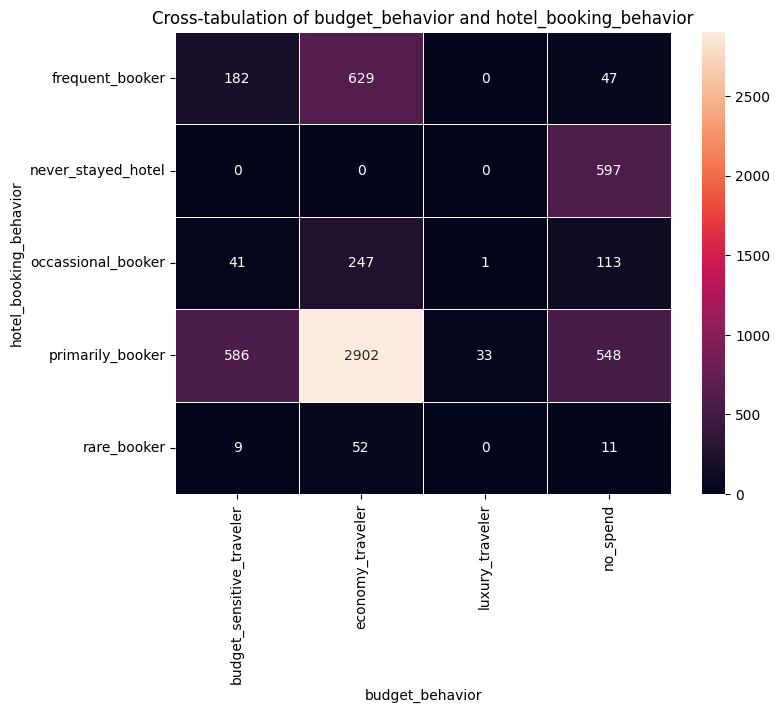

In [34]:


dd = pd.crosstab(df_data["hotel_booking_behavior"], df_data["budget_behavior"])

plt.figure(figsize=(8, 6))
sns.heatmap(dd, annot=True, fmt="d", linewidths=0.5)
plt.title('Cross-tabulation of budget_behavior and hotel_booking_behavior')
plt.show()


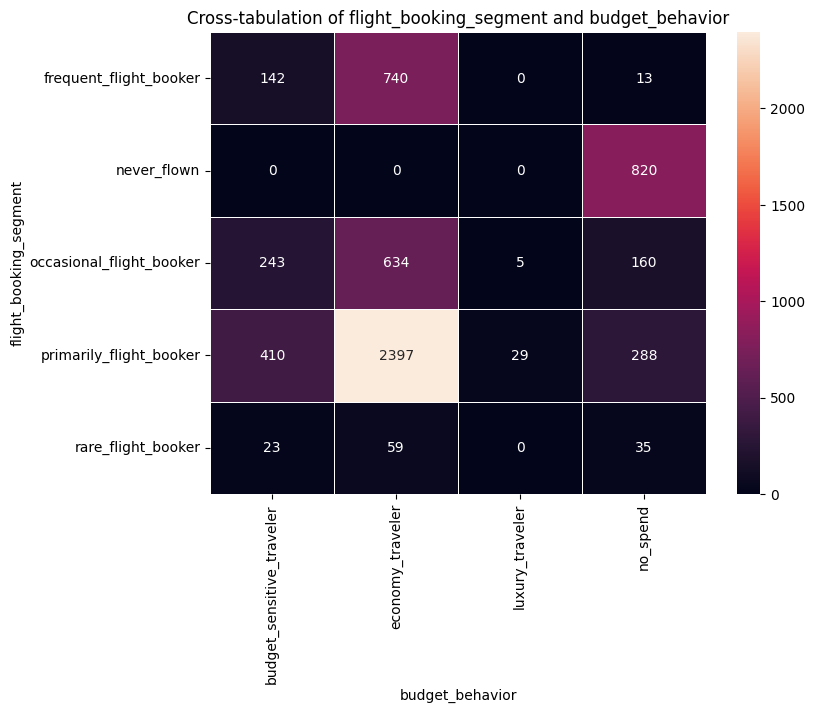

In [35]:
dd = pd.crosstab(df_data["flight_booking_segment"], df_data["budget_behavior"])

plt.figure(figsize=(8, 6))
sns.heatmap(dd, annot=True, fmt="d", linewidths=0.5)
plt.title('Cross-tabulation of flight_booking_segment and budget_behavior')
plt.show()


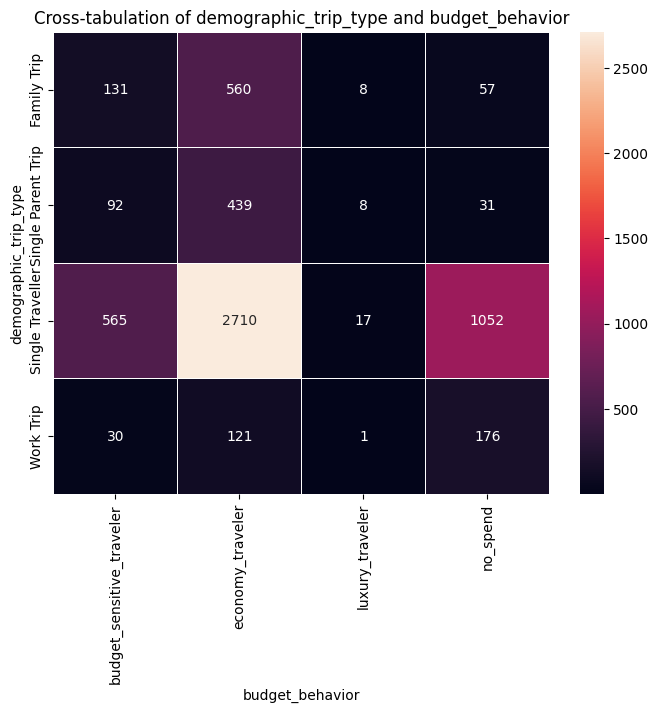

In [36]:

dd = pd.crosstab(df_data["demographic_trip_type"], df_data["budget_behavior"])

plt.figure(figsize=(8, 6))
sns.heatmap(dd, annot=True, fmt="d", linewidths=0.5)
plt.title('Cross-tabulation of demographic_trip_type and budget_behavior')
plt.show()


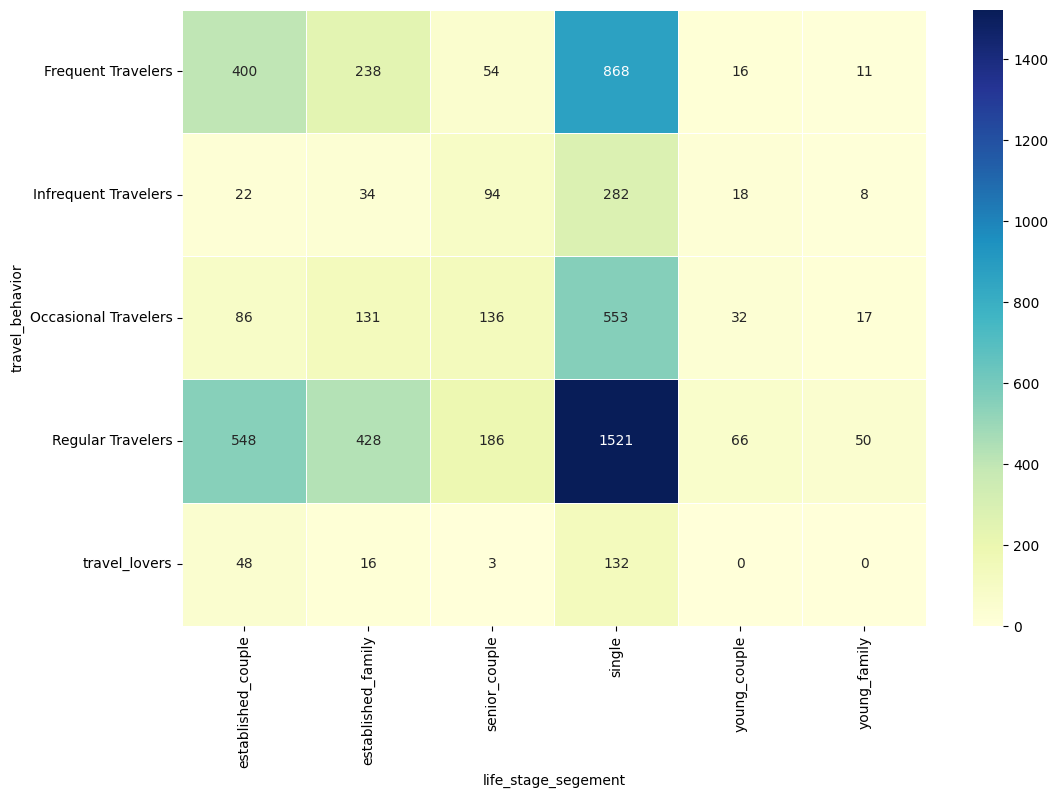

In [37]:


dd = pd.crosstab(df_data["travel_behavior"], df_data["life_stage_segement"])

plt.figure(figsize=(12, 8))  # Adjust figure size for better readability
sns.heatmap(dd, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", annot_kws={"size": 10})
#plt.title('Cross-tabulation of Budgetary Behavior, Family Travel Status, and Flight/Trip Booking')
#plt.xlabel('Family Travel Status')
#plt.ylabel('Travel behavior')
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
#plt.yticks(rotation=0)  # Keep y-axis labels horizontal
#plt.tight_layout()
plt.show()

# 7- Results of Rule Based clustring.
It brings us 4 clusters.

**cluster_1. (Free_Birds):**
- mainly not married, no kids
- travel_behavior is Frequent Travelers (<= 5 total_successfull_trip >= 4)
- flight_booking_segment is frequent_flight_booker (flight_trip_ratio is in between 1.5 to 2)
- hotel_booking_behavior is frequent_booker (hotel_trip_ratio is >=0.7 and <=0.8)

This cluster is dominated by travellers without children, frequent flight bookers who sometimes  don't book return flights and frequently book hotels. They are mostly frequent travelers taking 4-5 trips.

Behavior Summary:

Independent, frequent travelers prioritizing flights and often needing hotel stays. Their open return flight booking suggests flexibility or potentially last-minute planning.


**Suggested Travel Perks:**
- "Flexi-Flyer Pass":
 A subscription-based model offering discounted one-way flights and last-minute return options with minimal change fees.

- "Urban Explorer" Hotel Credits: Loyalty points earned quickly on hotel stays, redeemable for stays in vibrant city centers or boutique hotels.

Reasoning:
It caters to their frequent travel and hotel booking habits, common among single, active individuals. This also acknowledges their need for flexible return flights and interest in exploring urban destinations.




**cluster_2 (Dreamers):**

- life_stage_segement is single people dominant
- hotel_stay_behavior is medium_stay_visitor (avg hotel stay <=5)
- flight_booking_segment they have highest number of never flown people
- budget_behavior they have highest no spending people

This cluster is composed of single, infrequent travelers who show no significant spending patterns mentioned.


**Suggested Travel Perks:**
- "Welcome Aboard" Introductory Offers: Significant discounts on first-time flight and hotel bookings, coupled with flexible cancellation policies.

- "Bring a Friend" Rewards: Incentivizing them to travel with others by offering discounts or benefits for group bookings.

Reason:

Reason:As infrequent travelers with no strong spending patterns, the initial focus is to encourage them to travel with attractive entry-level offers and build confidence in booking, making it more appealing by sharing the experience.


**cluster_3 (Family_Travellers):**
- high number of single people but highest number of people having children, out of all clusters
- travel_behavior is Regular Travelers (<= 3 total_successfull_trip >= 2)
- majority has hotel_stay_behavior as medium_stay_visitors (<=5 avg hotel stay >=3 )
- budget_behavior os most of the user in this class is economy_traveler ( `5000>avg_spend_per_trip<1000` in dollars)

It has the highest proportion of people with children among all clusters is a significant insight. They are primarily flight bookers and medium-stay hotel visitors taht travel regularly.

**Suggested Travel Perks:**
- Family saver packages: Partnering with hotels that offer amenities like kids' clubs, cribs, or connecting rooms, bundled with short flight stays at discounted rates.


- Discounts on family attractions at destination: Collaborating with local attractions (e.g., theme parks, museums with children's areas) to offer discounted tickets or family passes when booking flights and short hotel stays.


Reasoning:
 This directly addresses the needs of individuals traveling with children for short durations, making these trips more convenient and affordable. Additionally, it enhances their trip value by making family-oriented activities more accessible and appealing.


**cluster_4 (Explorer):**
- mainly unmarried people
- flight_booking_segment is primarily_flight_booker have booked flight for every trip(flight_trip_ratio = 2.0)
- highest number of traveller who rarely book hotel


Behavior Summary:
Primarliy flight users, mailny un married but active travelers they tend to stay in hotels for a short stay.


**Suggested Travel Perks:**
- Destination-based offers: Highlighting attractions, tours, or local experiences at their likely travel destinations to incentivize flight bookings.

- "Extended Stay Saver" Hotel Deals: Discounts for hotel stays of 3 nights or more, potentially including value-added benefits like free breakfast or local transport passes.


Reasoning:
These perks aim to make flight and hotel combinations more attractive and cost-effective by acknowledging their broader travel habits, flight booking and preference for short-length hotel stays.



# 8- Features Preparation





## Feature encoding and Scaling

In [38]:


def encode_and_scale(df):
    """
    Encodes non-numerical columns and scales the entire DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The encoded and scaled DataFrame.
    """
    # Store 'user_id' separately
    df_data_1 = df_data.drop(columns=['user_id'])#  Drop 'user_id' before encoding and scaling

    # Select non-numerical columns (including boolean, categorical, and object)

    non_numerical_cols = df_data_1.select_dtypes(exclude=['number']).columns.tolist()


    # Create a copy of the DataFrame to avoid modifying the original
    encoded_df = df_data_1.copy()

    # Label encode non-numerical columns
    for col in non_numerical_cols:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(df_data_1[col])

    # Scale the entire DataFrame
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(encoded_df)
    scaled_df = pd.DataFrame(scaled_data, columns=encoded_df.columns, index=encoded_df.index)
    #scaled_df['user_id'] = df_data['user_id']

    return scaled_df

# Assuming your DataFrame is called 'df_data'
scaled_df_data = encode_and_scale(df_data)
#print(scaled_df_data.head())

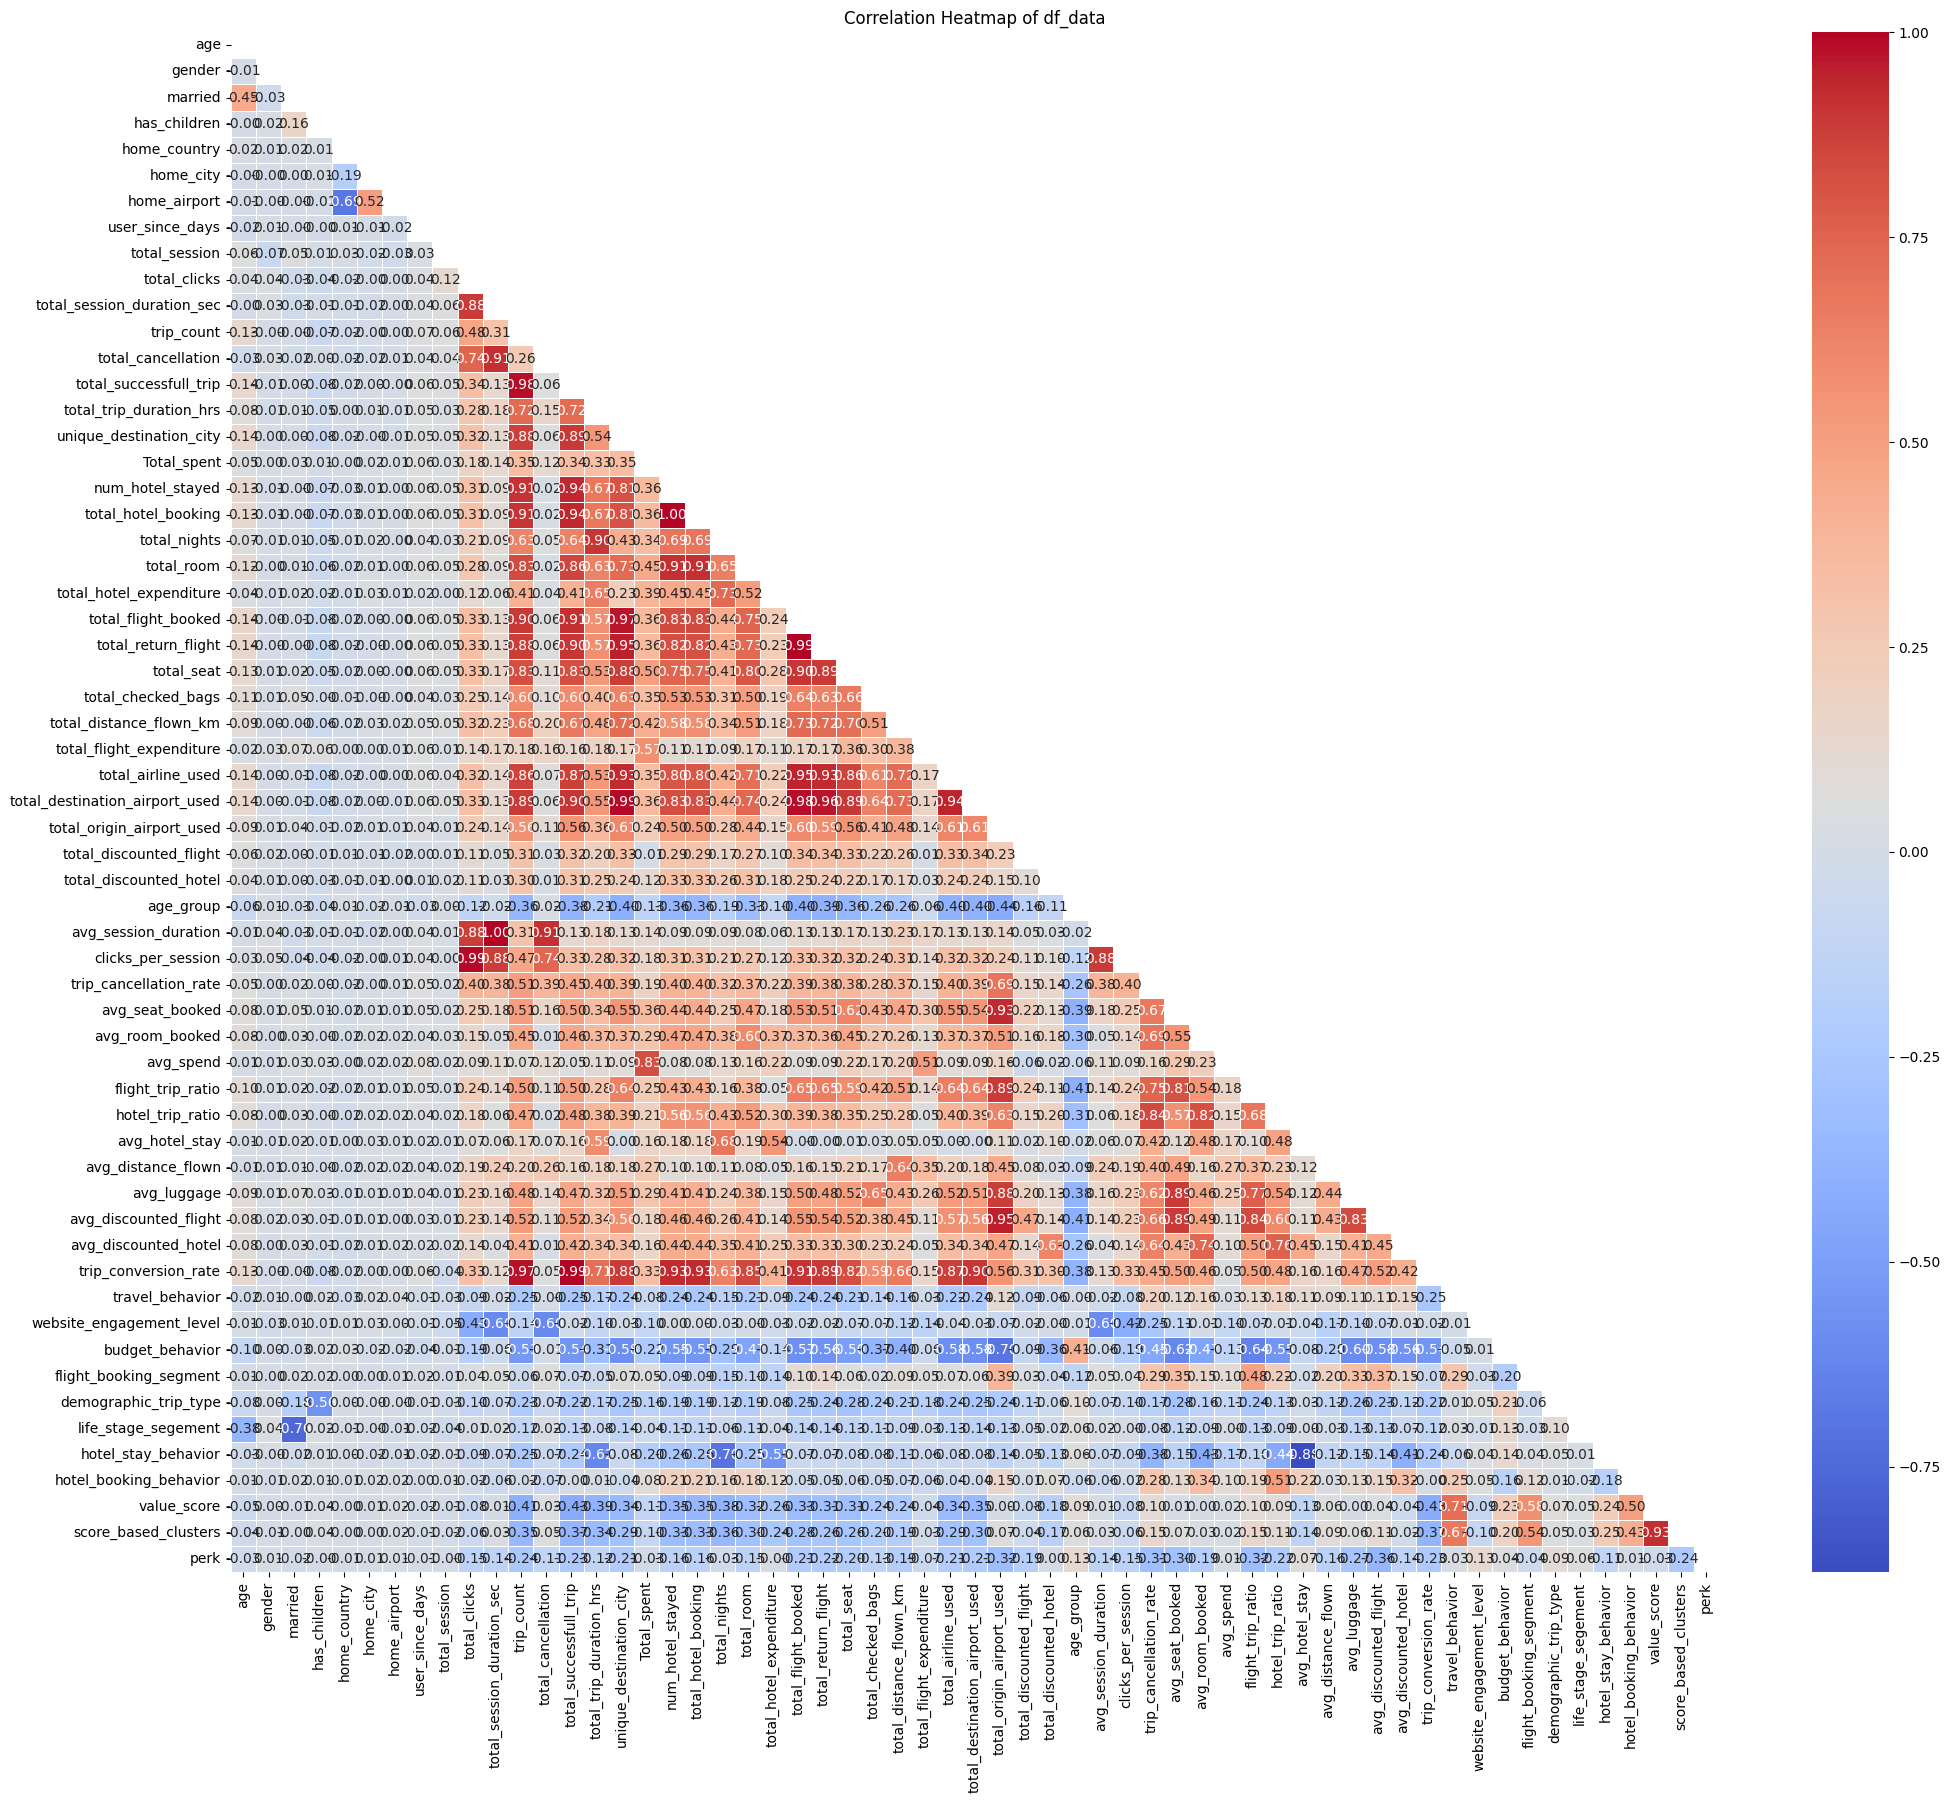

In [39]:
# Correlation Graphs

# Calculate the correlation matrix
corr_matrix = scaled_df_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # For upper triangle

# Create the heatmap
plt.figure(figsize=(24, 20))  # Adjust figure size as needed
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of df_data')
plt.show()

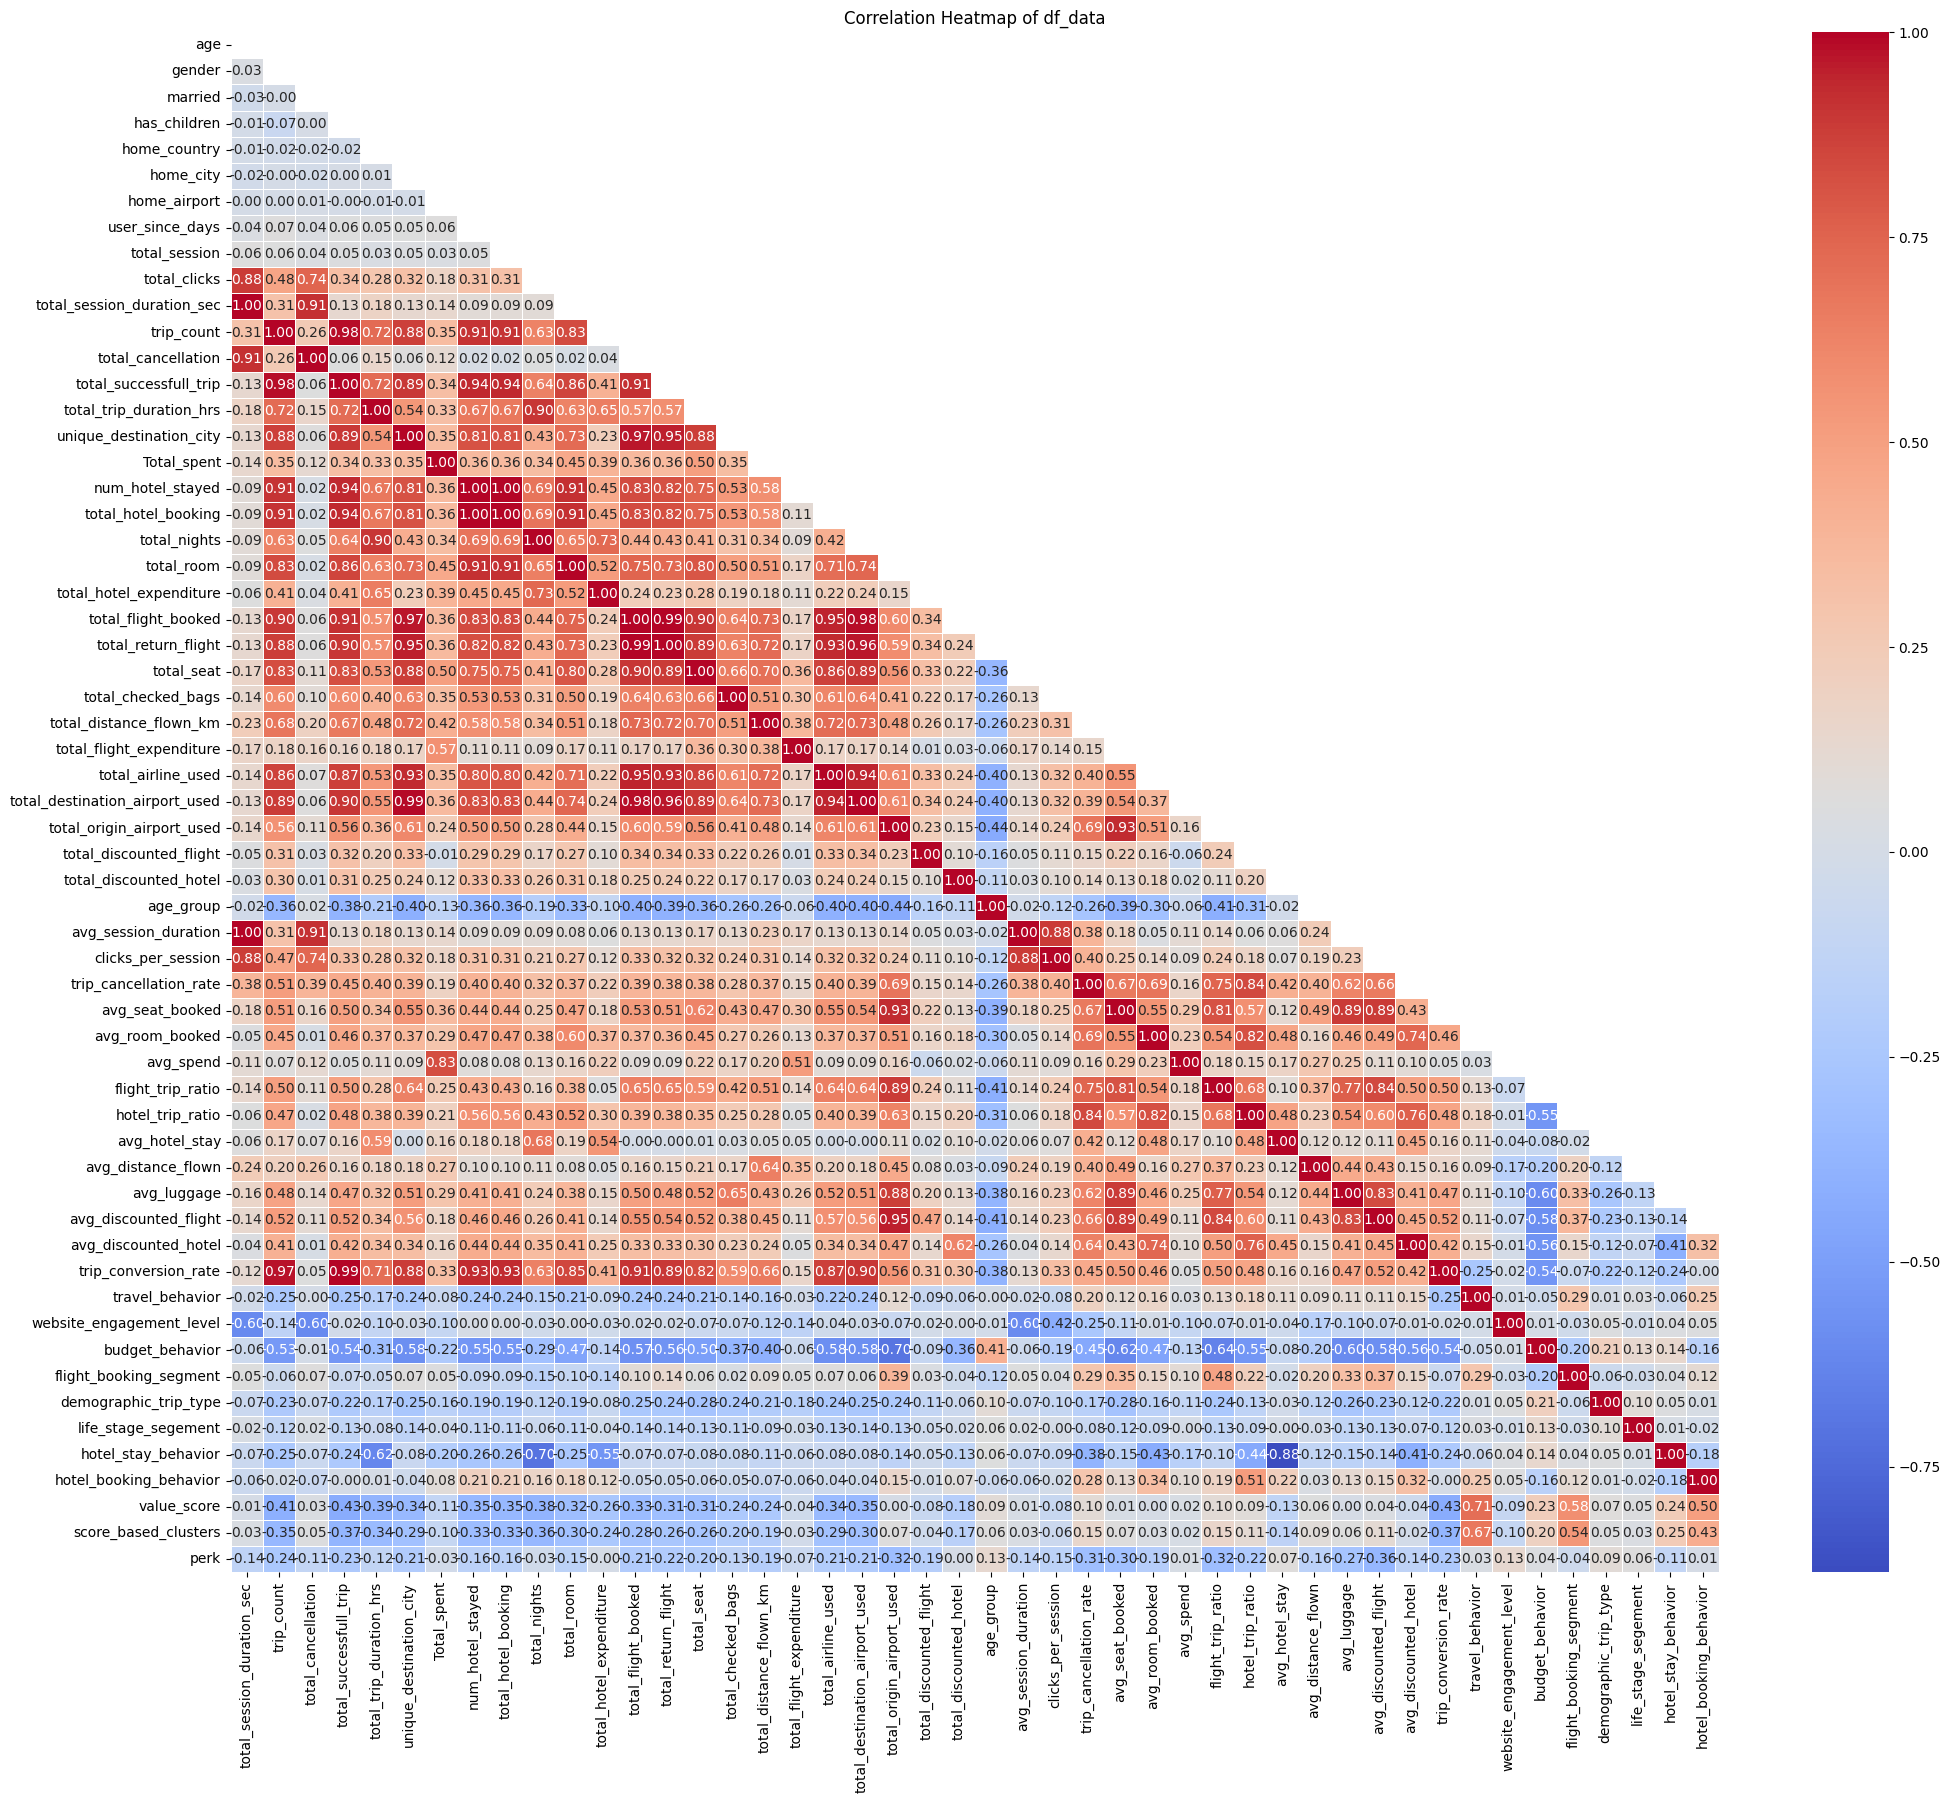

In [40]:
# Correlation Graphs

irrelevant_columns = ['age', 'gender', 'married', 'has_children', 'home_country', 'home_city',
                      'home_airport', 'user_since_days', 'total_session', 'total_clicks',
                      'value_score', 'score_based_clusters', 'perk',
                      ]
# Calculate the correlation matrix
corr_matrix = scaled_df_data.corr()
corr_matrix = corr_matrix.drop(columns=irrelevant_columns)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # For upper triangle

# Create the heatmap
plt.figure(figsize=(24, 20))  # Adjust figure size as needed
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of df_data')
plt.show()

# 9- PCA

PCA is a dimensionality reduction technique that transforms high-dimensional data into fewer dimensions while retaining most of the variance (information).

It identifies the principal components, or directions of maximum variance, and projects the data onto these components to simplify analysis and visualization.

####Finding the Optimal Number of PCA Components Based on Cumulative Explained Variance

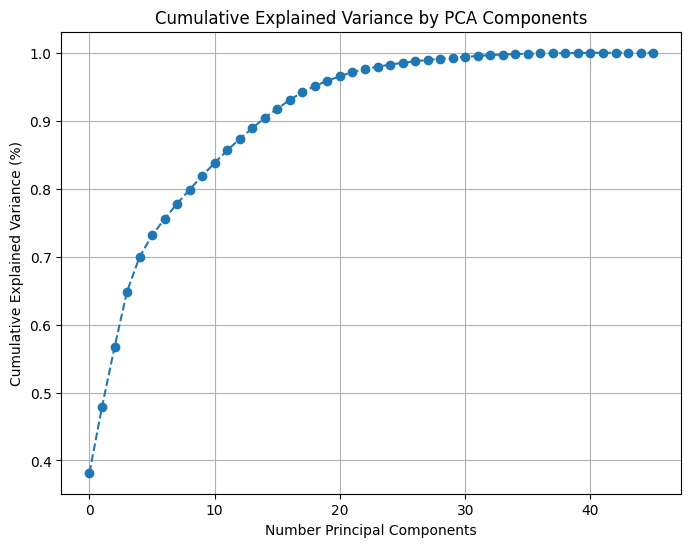

In [41]:
# Initialize PCA with all components except irrelevant columns found in correlation graph
scaled_df_data = scaled_df_data.drop(columns=irrelevant_columns)

pca_full = PCA()
pca_full.fit(scaled_df_data)

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

From the cumulative variance plot, selecting 30 components appears to be a suitable choice for dimensionality reduction, as they capture a significant portion of the total variance.

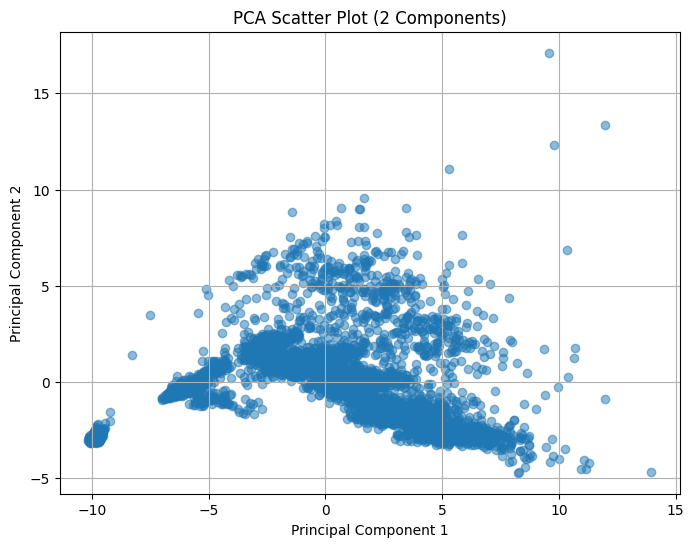

In [42]:
# PCA to reduce the feature dimensions to 30
pca = PCA(n_components=30)

# Conduct the PCA
scaled_pca = pca.fit_transform(scaled_df_data)


# Convert to dataframe
pcs = ['pc_'+ str(x) for x in range(1,31)]

pca_df = pd.DataFrame(data = scaled_pca, columns = pcs)
pca_df.head()

# Apply PCA to visualise in 2D
pca_2 = PCA(n_components=2)  # Choose the desired number of components
pca_2d = pca.fit_transform(scaled_df_data)

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], alpha=0.5)  # Plot the data points
plt.title('PCA Scatter Plot (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



# 10-  Applying clustering algorithms

#### Kmeans

It groups data points into K clusters based on their similarity. It works by assigning each data point to the nearest cluster center (centroid), then updates the centers to make the clusters as similar as possible.

#### Finding the Optimal K value based on Elbow method

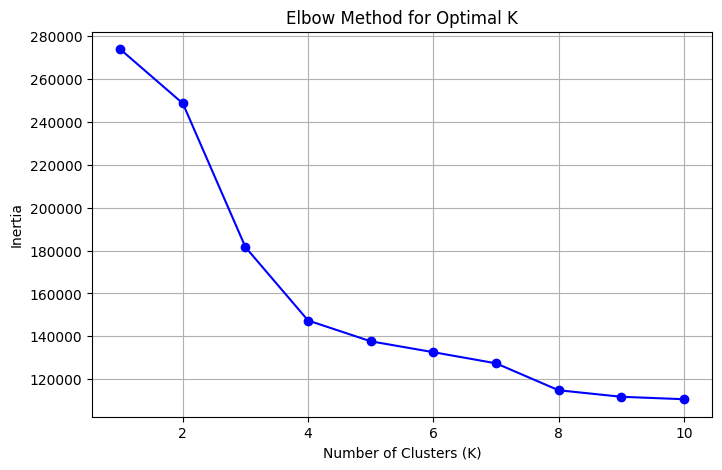

In [43]:
inertia = []
#Inertia (how far data points are from their assigned cluster centers — lower is better)


# Try K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)

    ## Fit KMeans to the data
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

 # Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Elbow Method: Look for the "elbow" point, where the graph starts to flatten and inertia starts to decrease at a slower rate.

In this case, the optimal number of clusters is taken as 3.



In [44]:
# Apply KMeans with  clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_df)

# Assign cluster labels to the training data
clusters = kmeans.predict(pca_df)
df_data['cluster'] = clusters

#uncomment to see for EDA
#print(df_data[df_data['cluster']==0].describe(include='object').T)
#print(df_data[df_data['cluster']==1].describe(include='object').T)
#print(df_data[df_data['cluster']==2].describe(include='object').T)


# Evaluate the clustering quality using Silhouette score
#silhouette_score is a way to measure how well your data has been clustered
df_data.to_csv('df_data.csv', index=False)
print(f"Silhouette Score : {silhouette_score(scaled_pca, clusters)}")

# Compare clusters with rule-based segmentation
comparison = pd.crosstab(df_data['score_based_clusters'], df_data['cluster'])
print(comparison)


Silhouette Score : 0.3443022085786518
cluster                 0     1    2
score_based_clusters                
cluster_1             102   970    0
cluster_2             136  1449  638
cluster_3             144  1747  236
cluster_4             118   456    2


## Experiments with selected columns

In [45]:
exp_columns = {'exp1' : [
                    # Expenditure Features
                    'Total_spent',
                    'total_flight_expenditure',
                    'avg_spend',
                    'total_hotel_expenditure',
                    'budget_behavior',        # 3. Used in Segmentation


                    # Hotel Features
                    'total_hotel_booking',
                    'avg_hotel_stay',
                    'hotel_stay_behavior',    # 7. Used in Segmentation
                    'hotel_booking_behavior', # 8. Used in Segmentation

                    # Flight Features
                    'total_flight_booked',
                    'total_return_flight',
                    'flight_booking_segment', # 4. Used in Segmentation

                    # Website Features
                    'avg_session_duration',
                    'clicks_per_session',
                    'website_engagement_level', # 2. Used in Segmentation

                    # Trip Features
                    'travel_behavior',        # 1. Used in Segmentation
                    'trip_cancellation_rate',
                    'flight_trip_ratio',
                    'hotel_trip_ratio',
                    'avg_discounted_flight',  #
                    'avg_discounted_hotel',   #
                    'trip_conversion_rate',   #
                    'demographic_trip_type',  # 5.
                    'life_stage_segement',    # 6.
                  ],

                  'exp2' : [
                     # Expenditure Features
                    'budget_behavior',        # 3. Used in Segmentation

                    # Hotel Features
                    'hotel_stay_behavior',    # 7. Used in Segmentation
                    'hotel_booking_behavior', # 8. Used in Segmentation

                    # Flight Features
                    'flight_booking_segment', # 4. Used in Segmentation

                    # Website Features
                    'website_engagement_level', # 2. Used in Segmentation

                    # Trip Features
                    'travel_behavior',        # 1. Used in Segmentation
                    'demographic_trip_type',  # 5.
                    'life_stage_segement',    # 6.
                  ],
                'exp3' : [
                 # Expenditure Features
                    'budget_behavior',        # 3. Used in Segmentation

                    # Hotel Features
                    'hotel_stay_behavior',    # 7. Used in Segmentation
                    'hotel_booking_behavior', # 8. Used in Segmentation

                    # Flight Features
                    'flight_booking_segment', # 4. Used in Segmentation

                    # Website Features
                    'website_engagement_level', # 2. Used in Segmentation

                    # Trip Features
                    'travel_behavior',        # 1. Used in Segmentation
                ],
               'exp4': scaled_df_data.columns.tolist(),
                  }


In [46]:
def get_pc_df(exp_df_data):
  pca_full = PCA()
  pca_full.fit(exp_df_data)

  # number of pca components to cover atleast 95% varience
  n_components = list(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95).index(True)

  # PCA to reduce the feature dimensions to n_componets
  pca = PCA(n_components=n_components)

  # Conduct the PCA
  scaled_pca = pca.fit_transform(exp_df_data)


  # Convert to dataframe
  pcs = ['pc_'+ str(x) for x in range(1,n_components+1)]
  pca_df = pd.DataFrame(data = scaled_pca, columns = pcs)
  return pca_df
for exp, col in exp_columns.items():

  pca_df = get_pc_df(scaled_df_data[col])

  data_cols = [scaled_df_data[col], pca_df]

  for i, col_x in enumerate(data_cols):
    if i == 0: print(f'Experiment with scaled_df_data with {col_x.shape[1]} columns')
    else: print(f'Experiment with pca_df with pc componets {pca_df.shape[1]}')
    # Apply KMeans with  clusters
    for n in range(3,9):
      kmeans_exp = KMeans(n_clusters=n, random_state=42)
      kmeans_exp.fit(col_x)
      clusters_exp = kmeans_exp.predict(col_x)
      #df_data['cluster_exp3'] = clusters_exp3

      # Evaluate the clustering quality using Silhouette score
      #silhouette_score is a way to measure how well your data has been clustered
      print(f"Silhouette Score_Kmeans_{n}_{exp} : {silhouette_score(col_x, clusters_exp):.3f}")
    print('-'* 30)
  print('='*50)


Experiment with scaled_df_data with 24 columns
Silhouette Score_Kmeans_3_exp1 : 0.354
Silhouette Score_Kmeans_4_exp1 : 0.257
Silhouette Score_Kmeans_5_exp1 : 0.189
Silhouette Score_Kmeans_6_exp1 : 0.253
Silhouette Score_Kmeans_7_exp1 : 0.202
Silhouette Score_Kmeans_8_exp1 : 0.201
------------------------------
Experiment with pca_df with pc componets 13
Silhouette Score_Kmeans_3_exp1 : 0.369
Silhouette Score_Kmeans_4_exp1 : 0.277
Silhouette Score_Kmeans_5_exp1 : 0.275
Silhouette Score_Kmeans_6_exp1 : 0.279
Silhouette Score_Kmeans_7_exp1 : 0.210
Silhouette Score_Kmeans_8_exp1 : 0.228
------------------------------
Experiment with scaled_df_data with 8 columns
Silhouette Score_Kmeans_3_exp2 : 0.214
Silhouette Score_Kmeans_4_exp2 : 0.240
Silhouette Score_Kmeans_5_exp2 : 0.230
Silhouette Score_Kmeans_6_exp2 : 0.227
Silhouette Score_Kmeans_7_exp2 : 0.241
Silhouette Score_Kmeans_8_exp2 : 0.293
------------------------------
Experiment with pca_df with pc componets 7
Silhouette Score_Kmeans_3

## Experiment with DBSCAN

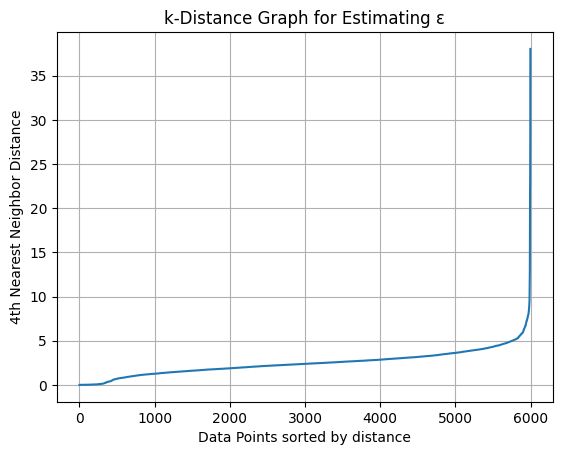

In [47]:
# Step 1: Estimate the Best ε Using the k-Distance Plot

# Use NearestNeighbors to compute the k-distance
neighbors = NearestNeighbors(n_neighbors=5)  # We use 5 because MinPts is usually set to 4 or 5
neighbors_fit = neighbors.fit(scaled_df_data)
distances, indices = neighbors_fit.kneighbors(scaled_df_data)

# Sort the distances to plot them
distances = np.sort(distances[:, 4], axis=0)  # 4th index because of n_neighbors=5

# Plot the k-distance graph
plt.plot(distances)
plt.title("k-Distance Graph for Estimating ε")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

In [48]:
# Step 2: Choose MinPts
# A common heuristic for MinPts is MinPts = 2 * number_of_features, in our case dimensions are reduced from 18 to 5 using PCA.
min_samples = 2 * scaled_df_data.shape[1]  # 2 * number_of_features = 2 * 18 = 36
min_samples

92

In [49]:
for exp, col in exp_columns.items():
  # DBSCAN clustering

  pca_df = get_pc_df(scaled_df_data[col])
  data_cols = [scaled_df_data[col], pca_df]

  for i, col_x in enumerate(data_cols):
    if i == 0: print(f'Experiment with scaled_df_data with {col_x.shape[1]} columns')
    else: print(f'Experiment with pca_df with pc componets {pca_df.shape[1]}')

    for eps in range(2,7):
      min_samples = 2 * col_x.shape[1]  # 2 * number_of_features = 2 * 18 = 36
      dbscan = DBSCAN(eps=eps, min_samples=min_samples)
      dbscan_labels = dbscan.fit_predict(col_x)

      # Get the labels assigned by DBSCAN
      labels = dbscan.labels_
      # Filter out noise points (labeled as -1)
      filtered_data = scaled_df_data[labels != -1]
      filtered_labels = labels[labels != -1]

      # Calculate the silhouette score
      try:
        print(f"Silhouette Score_dbscan_eps_{eps}_{exp}, clusters_{len(set(filtered_labels))} : {silhouette_score(filtered_data, filtered_labels):.3f}")
      except Exception as e:
        print(f"Silhouette Score_dbscan_eps_{eps}_{exp} : {e}")
    print('-'*30)
  print('='*50)

Experiment with scaled_df_data with 24 columns
Silhouette Score_dbscan_eps_2_exp1, clusters_7 : 0.225
Silhouette Score_dbscan_eps_3_exp1, clusters_4 : 0.328
Silhouette Score_dbscan_eps_4_exp1, clusters_2 : 0.412
Silhouette Score_dbscan_eps_5_exp1, clusters_2 : 0.408
Silhouette Score_dbscan_eps_6_exp1 : Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
------------------------------
Experiment with pca_df with pc componets 13
Silhouette Score_dbscan_eps_2_exp1, clusters_6 : 0.283
Silhouette Score_dbscan_eps_3_exp1, clusters_4 : 0.304
Silhouette Score_dbscan_eps_4_exp1, clusters_3 : 0.313
Silhouette Score_dbscan_eps_5_exp1 : Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Silhouette Score_dbscan_eps_6_exp1 : Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
------------------------------
Experiment with scaled_df_data with 8 columns
Silhouette Score_dbscan_eps_2_exp2, clusters_3 : 0.284
Silhouette Score_dbscan_eps_3_exp2, c

# 11- Results


- DBSCAN -> eps:3, in exp4 (46 columns), clusters: 3, have **silhoutte score of 0.528**
- KMEANS -> pca_df of exp1 (24 columns), with pc_componets: 13, clusters: 3, **have silhoutte score of 0.408**

As the silhoutte score is not very good, therefore rule based segmentation is followed to assign behavior specific perk to customers.

For cluster details please look into section the **''Results of Rule based Clustring''** of this Notebook.


# Results of Rule Based clustring.
It brings us 4 clusters.

**cluster_1. (Free_Birds):**
- mainly not married, no kids
- travel_behavior is Frequent Travelers (<= 5 total_successfull_trip >= 4)
- flight_booking_segment is frequent_flight_booker (flight_trip_ratio is in between 1.5 to 2)
- hotel_booking_behavior is frequent_booker (hotel_trip_ratio is >=0.7 and <=0.8)

This cluster is dominated by travellers without children, frequent flight bookers who sometimes  don't book return flights and frequently book hotels. They are mostly frequent travelers taking 4-5 trips.

Behavior Summary:

Independent, frequent travelers prioritizing flights and often needing hotel stays. Their open return flight booking suggests flexibility or potentially last-minute planning.


**Suggested Travel Perks:**
- "Flexi-Flyer Pass":
 A subscription-based model offering discounted one-way flights and last-minute return options with minimal change fees.

- "Urban Explorer" Hotel Credits: Loyalty points earned quickly on hotel stays, redeemable for stays in vibrant city centers or boutique hotels.

Reasoning:
It caters to their frequent travel and hotel booking habits, common among single, active individuals. This also acknowledges their need for flexible return flights and interest in exploring urban destinations.




**cluster_2 (Dreamers):**

- life_stage_segement is single people dominant
- hotel_stay_behavior is medium_stay_visitor (avg hotel stay <=5)
- flight_booking_segment they have highest number of never flown people
- budget_behavior they have highest no spending people

This cluster is composed of single, infrequent travelers who show no significant spending patterns mentioned.


**Suggested Travel Perks:**
- "Welcome Aboard" Introductory Offers: Significant discounts on first-time flight and hotel bookings, coupled with flexible cancellation policies.

- "Bring a Friend" Rewards: Incentivizing them to travel with others by offering discounts or benefits for group bookings.

Reason:

Reason:As infrequent travelers with no strong spending patterns, the initial focus is to encourage them to travel with attractive entry-level offers and build confidence in booking, making it more appealing by sharing the experience.


**cluster_3 (Family_Travellers):**
- high number of singles but highest number of people having children, out of all clusters
- travel_behavior is Regular Travelers (<= 3 total_successfull_trip >= 2)
- majority has hotel_stay_behavior as medium_stay_visitors (<=5 avg hotel stay >=3 )
- budget_behavior os most of the user in this class is economy_traveler ( `5000>avg_spend_per_trip<1000` in dollars)

It has the highest proportion of people with children among all clusters is a significant insight. They are primarily flight bookers and medium-stay hotel visitors taht travel regularly.

**Suggested Travel Perks:**
- Family saver packages: Partnering with hotels that offer amenities like kids' clubs, cribs, or connecting rooms, bundled with short flight stays at discounted rates.


- Discounts on family attractions at destination: Collaborating with local attractions (e.g., theme parks, museums with children's areas) to offer discounted tickets or family passes when booking flights and short hotel stays.


Reasoning:
 This directly addresses the needs of individuals traveling with children for short durations, making these trips more convenient and affordable. Additionally, it enhances their trip value by making family-oriented activities more accessible and appealing.


**cluster_4 (Explorer):**
- mainly unmarried people
- flight_booking_segment is primarily_flight_booker have booked flight for every trip(flight_trip_ratio = 2.0)
- highest number of traveller who rarely book hotel


Behavior Summary:
Primarliy flight users, mailny un married but active travelers they tend to stay in hotels for a short stay.


**Suggested Travel Perks:**
- Destination-based offers: Highlighting attractions, tours, or local experiences at their likely travel destinations to incentivize flight bookings.

- "Extended Stay Saver" Hotel Deals: Discounts for hotel stays of 3 nights or more, potentially including value-added benefits like free breakfast or local transport passes.


Reasoning:
These perks aim to make flight and hotel combinations more attractive and cost-effective by acknowledging their broader travel habits, flight booking and preference for short-length hotel stays.

